# Pivot and Graph Functions

By Kenneth Burchfiel

Released under the MIT License

This notebook will demonstrate how to use functions to simplify the Plotly graphing process. These functions will also prove useful within the online visualizations section of Python for Nonprofits.

As shown in the graphing.ipynb notebook within this section, pivot tables play a crucial role in generating Plotly charts. They allow you to turn a raw dataset into a table of aggregate values that can easily be rendered as a bar graph, line graph, or alternative plot type. Thanks to the powerful pandas library, these tables are easy to produce within Python.

However, creating separate pivot tables for each graph still requires a decent amount of work. In addition, there are times when coding these pivot tables would be impractical. Suppose, for instance, that you're putting together an online dashboard that visualizes mean survey result scores in bar chart form. You would like to allow users to compare these scores by up to 6 potential variables: Starting Year, Season, Gender, Graduation Year, College, and Level. (In other words, they should be able to view these results by Season and College; College, Level, and Season; all 6 variables; and even no variables at all--in which case all results will be grouped into a single bar.)

If you wanted to create a pivot table for each of these comparison options, you'd end up having to construct *at least* 64 pivot tables. (There are 6 comparison options, each of which can either be present or absent--resulting in a total of 2^6 = 64 tables.) However, when you take the color variable option into account, you might need to produce up to 256 tables. In addition, if we consider x variable order to matter, the number of tables that must be created **will easily exceed 1,000**.*

In order to avoid creating hundreds or even thousands of pivot tables for this online dashboard, we'll need to create **an 'autopivot' function that, given a list of comparison variables, a y variable, and a color variable, returns a pivot table, x and y variables, and a color variable.** We will demonstrate such a function within this notebook. 

Although this pivot table function will play a pivotal (pun intended) role in our final graph, we'll also need to create a corresponding **'autobar' function that converts the output of the autopivot function into a graph.** (We could add this code into our main pivot table function, but separating the two allows other graph types--such as line charts--to be created rather than bar charts, thus making the code more versatile.)

\*The spreadsheet I used for these calculations can be found within this section's folder as color_combination_possibilities.xlsx. These can be analyzed as combination and permutation problems, although the presence of a color variable adds a bit more complexity. To be honest, I'm not certain about these calculations, but it's fair to say that the number of possible pivot tables (and charts) that could be created with up to 6 comparison options is . . . *a lot.*



In [1]:
import pandas as pd
import plotly.express as px
from sqlalchemy import create_engine
e = create_engine('sqlite:///../Appendix/nvcu_db.db')

import sys
sys.path.insert(1, '../Appendix')
from helper_funcs import config_notebook, wadi
display_type = config_notebook(display_max_columns = 5)
        

## Creating a detailed survey results dataset

This dataset will include data from both our survey results *and* enrollment tables, thus allowing for additional comparison options.

### Importing each dataset:

In [2]:
df_enrollment = pd.read_sql(
    'select * from curr_enrollment', con = e)
df_enrollment

first_name last_name  ... level  level_for_sorting
0       Brittany     Davis  ...    Fr                  0
1         Laurie    Martin  ...    Fr                  0
...          ...       ...  ...   ...                ...
16382      Aaron     Davis  ...    Se                  3
16383   Benjamin   Wilkins  ...    Se                  3

[16384 rows x 11 columns]

In [3]:
df_survey_results = pd.read_sql(
    'select * from survey_results', con = e)
df_survey_results

student_id  starting_year  season  score
0         2020-1           2023    Fall     88
1         2020-2           2023    Fall     37
...          ...            ...     ...    ...
32766  2023-5442           2023  Spring     64
32767  2023-5443           2023  Spring     77

[32768 rows x 4 columns]

### Merging these datasets together:

In [4]:
df_se = df_survey_results.merge(
    df_enrollment, on = 'student_id', how = 'left')
# The 'se' in df_se stands for 'survey and enrollment.'

# Removing columns that we're not interested in using for our 
# comparisons:
df_se.drop(
    ['student_id', 'first_name', 'last_name',
     'date_of_birth', 'matriculation_number'], 
    axis = 1, inplace = True)

# Reformatting our column names so that they'll show up better
# within graphs):

df_se.columns = [
    column.replace('_', ' ').title() 
    for column in df_se.columns]

df_se['Season For Sorting'] = (
    df_se[
'Season'].map({'Fall':0,'Winter':1,'Spring':2}))
df_se.sort_values(
    ['Season For Sorting', 'Level For Sorting'],
    inplace = True)

df_se.head()


Starting Year Season  ...  Level For Sorting Season For Sorting
0           2023   Fall  ...                  0                  0
1           2023   Fall  ...                  0                  0
2           2023   Fall  ...                  0                  0
3           2023   Fall  ...                  0                  0
4           2023   Fall  ...                  0                  0

[5 rows x 10 columns]

In [5]:
df_se['Responses'] = 1
df_se_pivot = df_se.pivot_table(
    index = ['Starting Year', 'Season', 'Gender', 
             'Matriculation Year', 'College', 'Class Of',
             'Level', 'Level For Sorting', 'Season For Sorting'],
    values = ['Score', 'Responses'],
    aggfunc = {'Score':'mean', 'Responses':'sum'}).reset_index()
df_se_pivot

Starting Year  Season  ... Responses      Score
0            2023    Fall  ...       408  69.583333
1            2023    Fall  ...       519  69.697495
..            ...     ...  ...       ...        ...
62           2023  Spring  ...       756  79.120370
63           2023  Spring  ...       858  78.083916

[64 rows x 11 columns]

## A basic autopivot function

The following code shows a simple version of an 'autopivot' function that can automatically create both pivot tables to be graphed and corresponding graphing variables. One key variable generated by this function is a field that groups together all of the individual comparison values passed to x_vars[] and can thus serve as the 'x' argument within a Plotly graph call.

This function has a number of limitations: for instance, it doesn't take color options into account, and it also can't accommodate variables that should be included in the *pivot table* function (e.g. for sorting purposes) but excluded from the *x variable column*. However, I chose to include it here in order to highlight the core concepts of this 'autopivot' function clearer. (The final autopivot function, shown later in this notebook, gets a bit more complicated.)



In [6]:
def autopivot_simple(df, y, aggfunc, x_vars = [],
                    overall_data_name = 'All Data'):
    '''This is a simple version of an 'autopivot' chart. Given a 
    DataFrame, a y variable, an aggregate function, and an arbitrary list 
    of variables, it will return a pivot table, an x variable, 
    and a y variable that can then get fed into a graphing function.

    For more documentation on these steps, 
    see the full autopivot function below. (I excluded that documentation
    from this code in order to prevent redundancy.)
    '''

    df_for_pivot = df.copy()
    df_for_pivot

    # Handling a situation in which no comparion variables were provided:
    if len(x_vars) == 0: 
        df_for_pivot[overall_data_name] = overall_data_name
        df_pivot = df_for_pivot.pivot_table(
            index = overall_data_name, values = y, 
            aggfunc = aggfunc).reset_index()
        x_val_name = overall_data_name
        color = overall_data_name
        barmode = 'relative'
        index = [overall_data_name]         
       
    else:
        print("x_vars:",x_vars)    

        # Creating a pivot table using the arguments provided:
        df_pivot = df_for_pivot.pivot_table(
            index = x_vars, values = y, aggfunc = aggfunc).reset_index()
        
        # Creating the x variable's column name:
        # (This name can then get fed into a graphing function.)
        x_val_name = ('/').join(x_vars)

        # Creating the values for this column:
        # (The function does so by combining each row's values for 
        # the fields represented in x_vars into a single string.)
        df_pivot[x_val_name] = df_pivot[x_vars[0]].astype('str')
        for i in range(1, len(x_vars)):
            df_pivot[x_val_name] = (
                df_pivot[x_val_name] 
                + '/' + df_pivot[x_vars[i]].astype('str'))
            
    return df_pivot, x_val_name, y, aggfunc

## A basic autobar function

The following function uses the output of autopivot_simple as inputs for a bar chart. It's quite limited relative to the final autobar function that will be shown later in this code, but it still demonstrates the utility of the autobar_simple function.

In [7]:
def autobar_simple(df_pivot, x_val_name, y, aggfunc):
    '''This function creates a bar graph of a pivot table (such as one
    created by autopivot_simple.
    For more documentation on this function, view the full autobar()
    function, which will be defined below.
    '''
    
    fig = px.bar(df_pivot, x = x_val_name, y = y, text_auto = '.0f',
                title = f"{aggfunc.title()} {y} by {x_val_name}") 
    return fig

## Testing out autopivot_simple and autobar_simple:

We'll first use these functions to graph average survey results by level and season:

x_vars: ['Level', 'Season']
Level/Season Score   Level  Season      Score Level/Season
0    Fr    Fall  69.698085      Fr/Fall
1    Fr  Spring  73.546671    Fr/Spring
2    Ju    Fall  69.688672      Ju/Fall
3    Ju  Spring  69.495124    Ju/Spring
4    Se    Fall  69.609774      Se/Fall


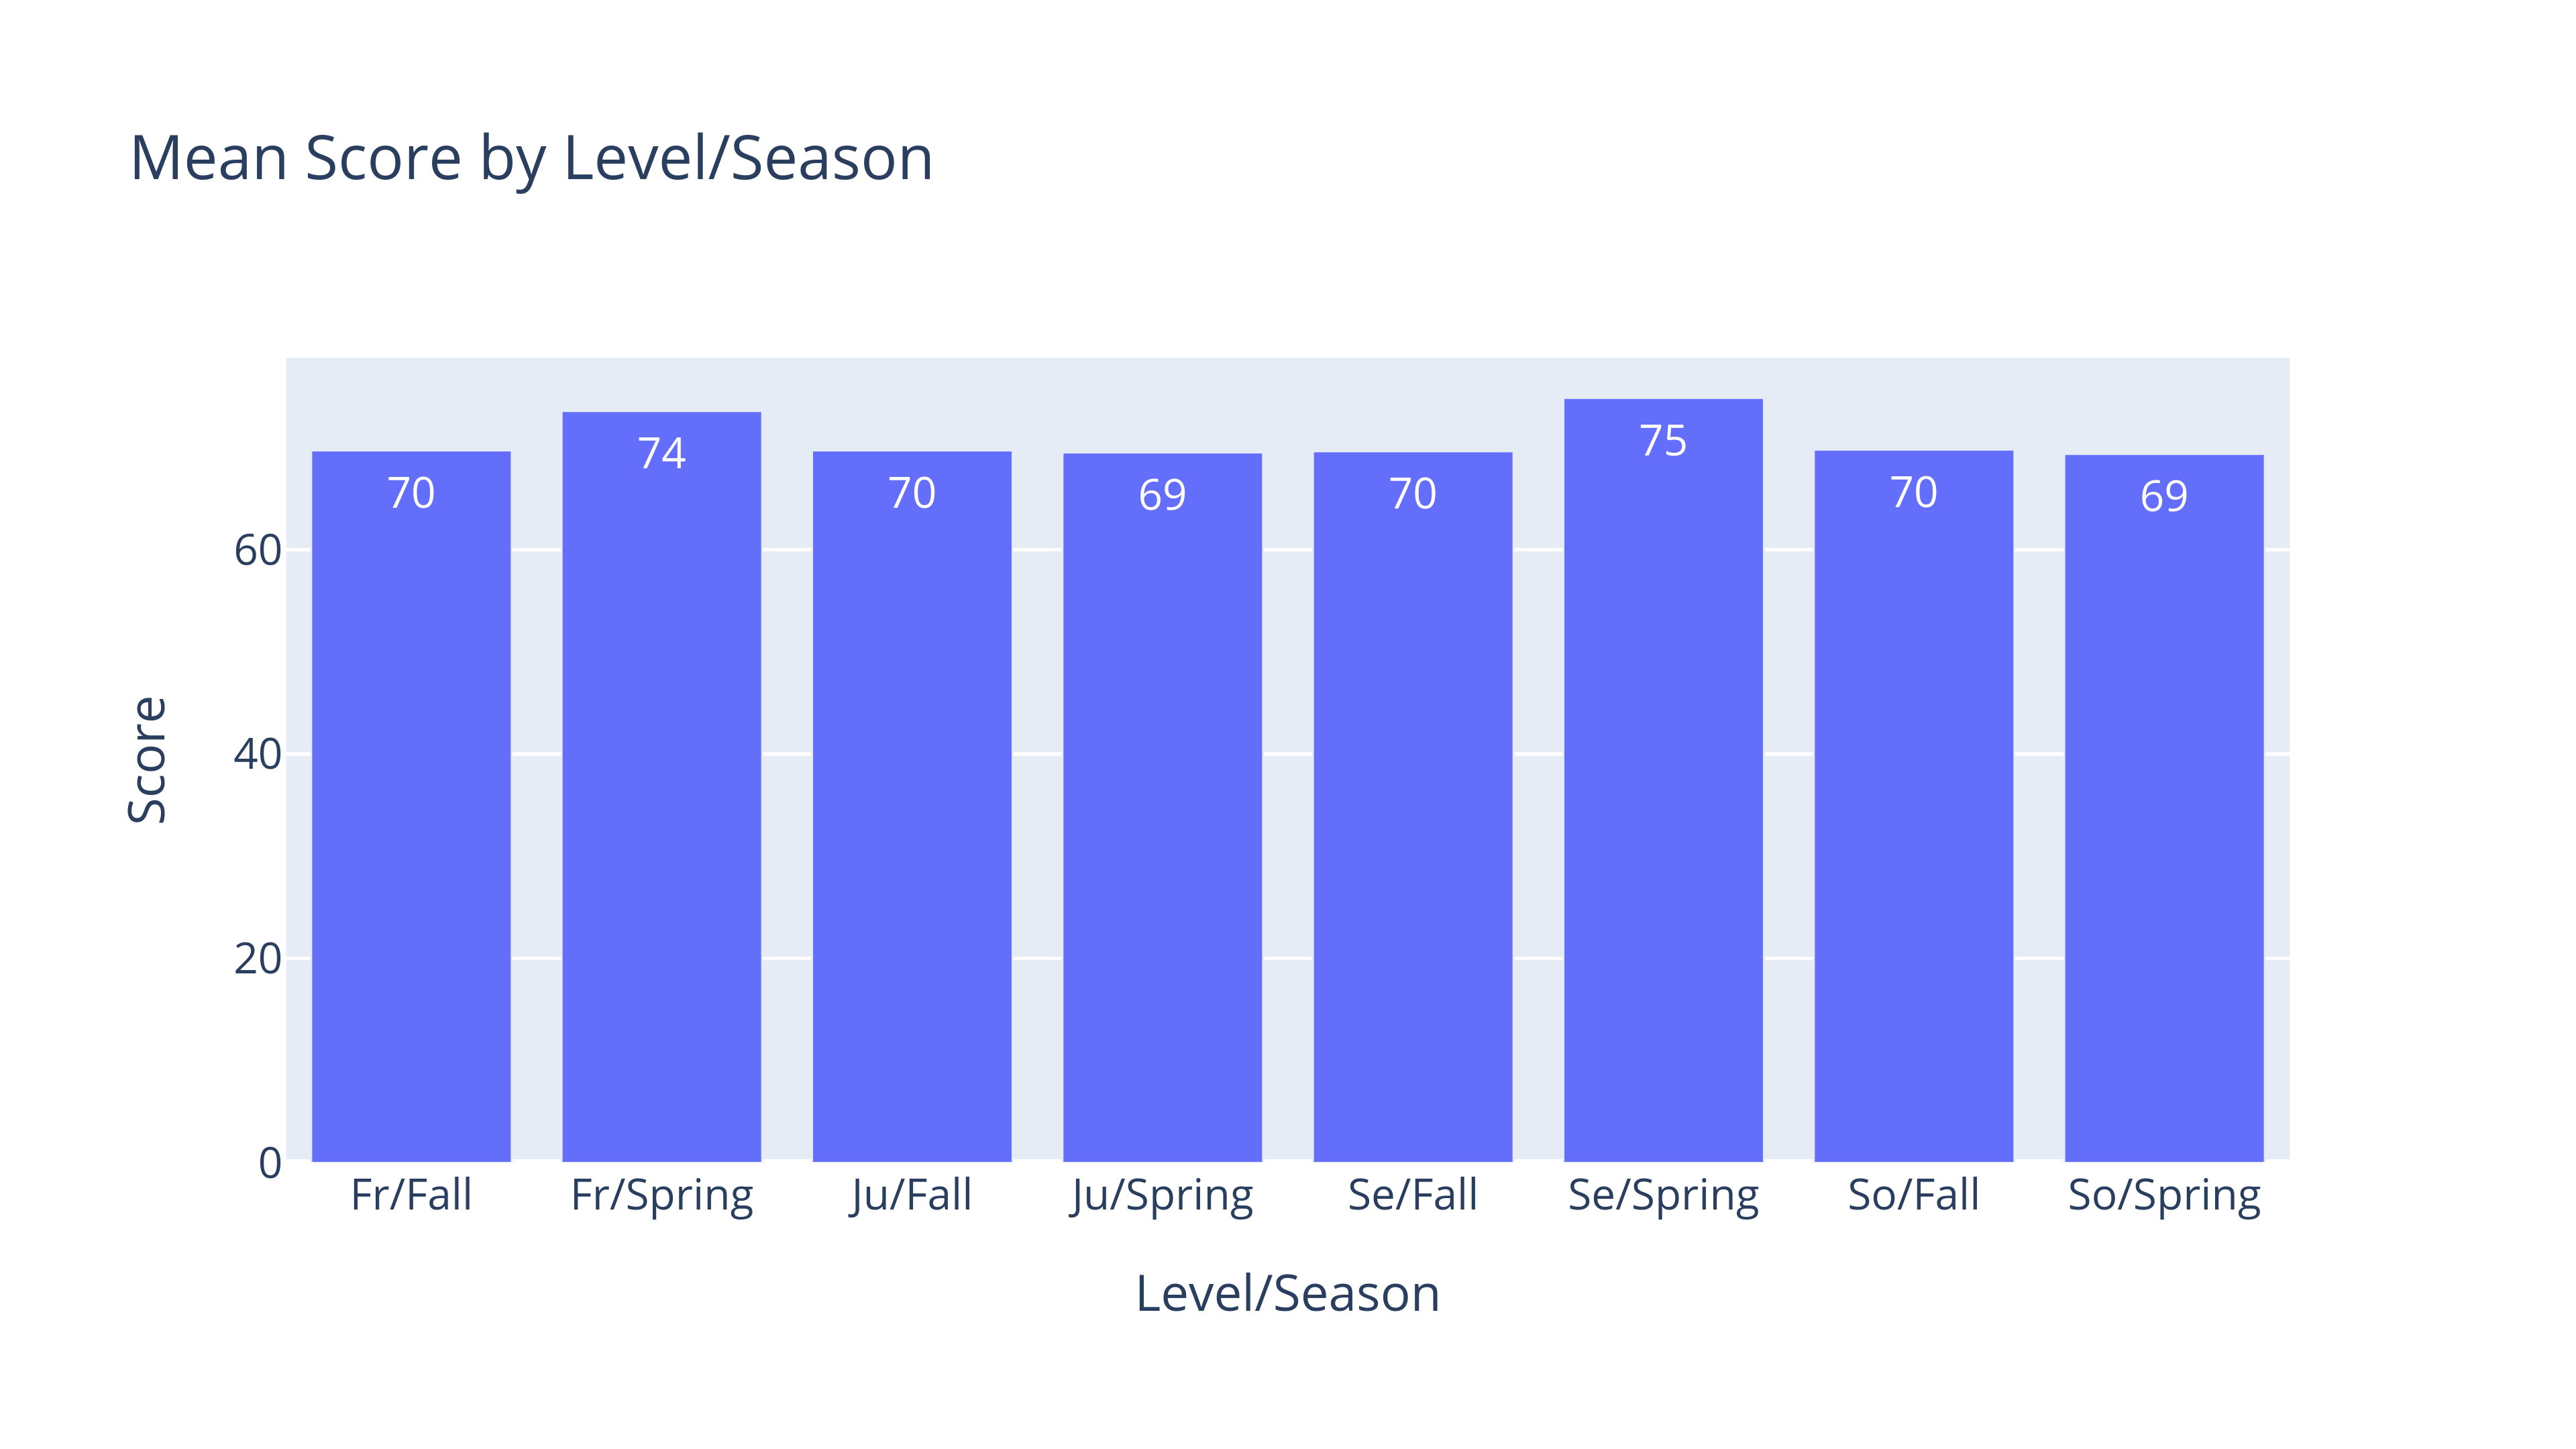

In [8]:
df_pivot, x_val_name, y, aggfunc = autopivot_simple(
    df_se, y = 'Score', aggfunc = 'mean', x_vars = ['Level', 'Season'])

print(x_val_name, y, df_pivot.head())
fig = autobar_simple(
    df_pivot = df_pivot, x_val_name = x_val_name, y = y,
aggfunc = aggfunc)                      

wadi(fig=fig, file_path='output/mean_score_by_level_and_season',
    display_type=display_type)

Next, we'll display these averages by season, college, and level:

x_vars: ['Season', 'College', 'Level']


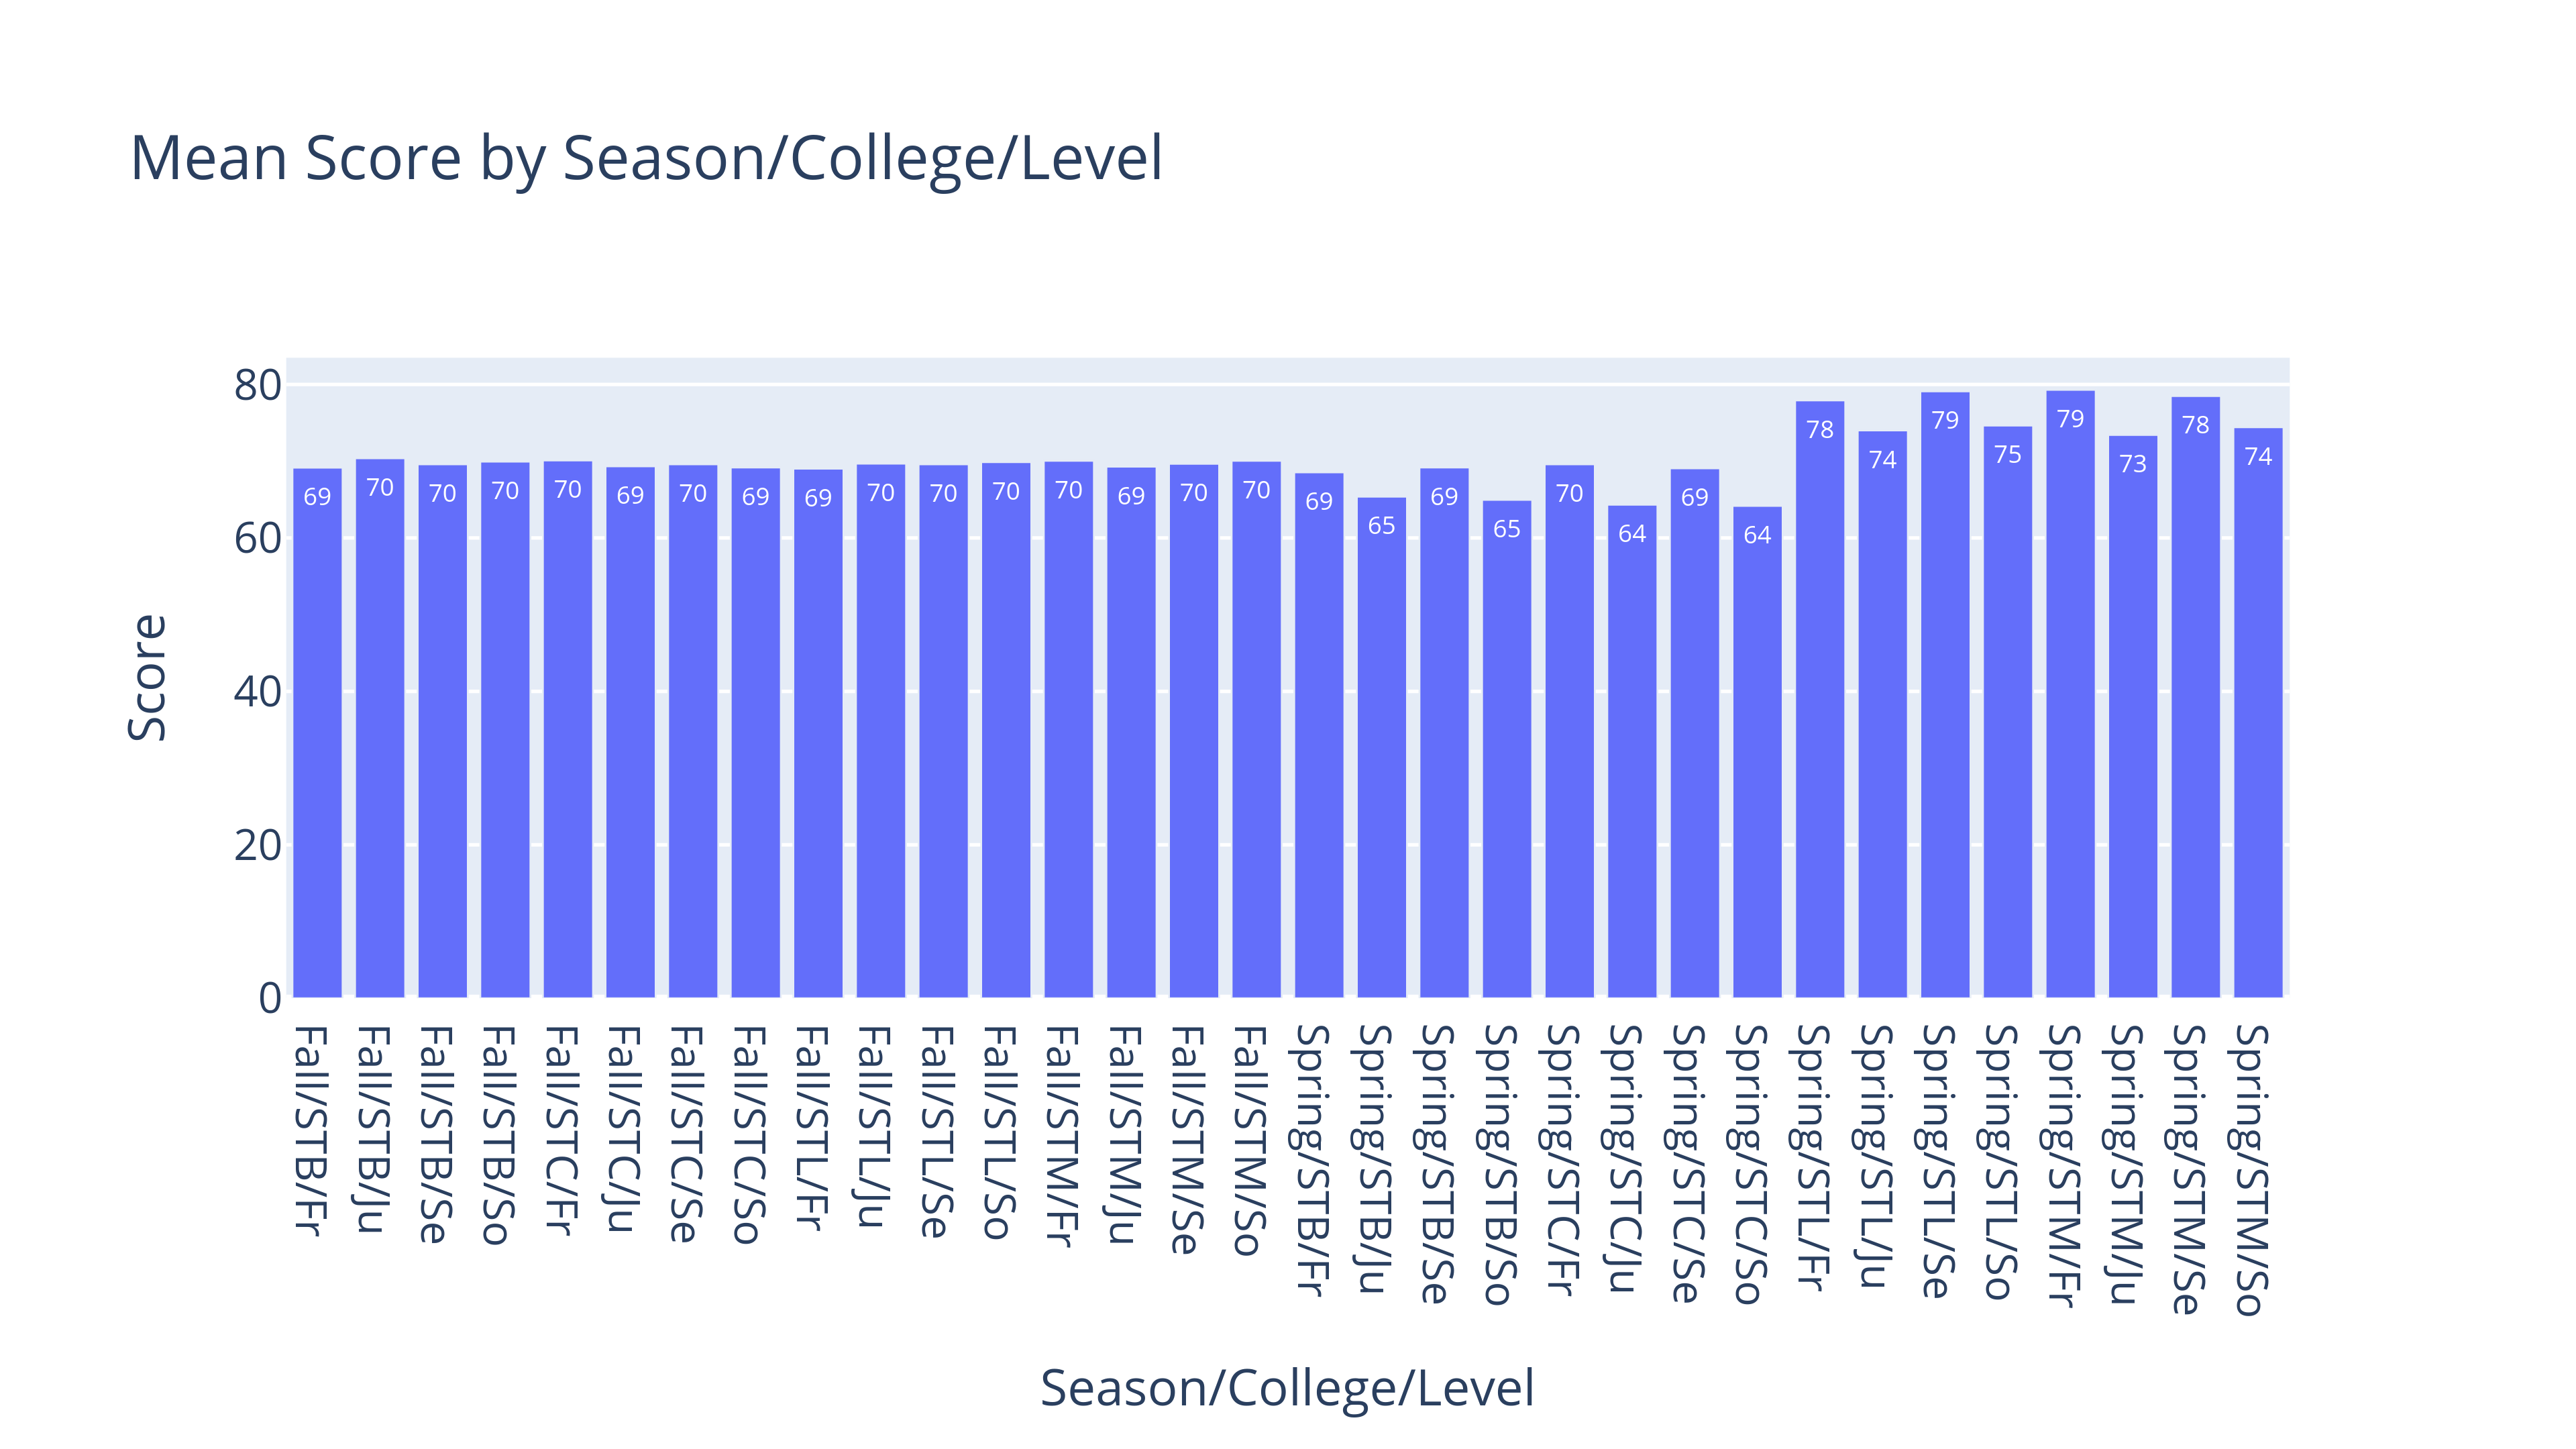

In [9]:
df_pivot, x_val_name, y, aggfunc = autopivot_simple(
    df_se, y = 'Score', aggfunc = 'mean', x_vars = [
        'Season', 'College', 'Level'])

fig = autobar_simple(
    df_pivot = df_pivot, x_val_name = x_val_name, y = y,
    aggfunc = aggfunc
    )                      

wadi(fig=fig, file_path='output/mean_score_by_season_college_and_level',
    display_type=display_type)

Finally, we'll create a chart that groups all data together:

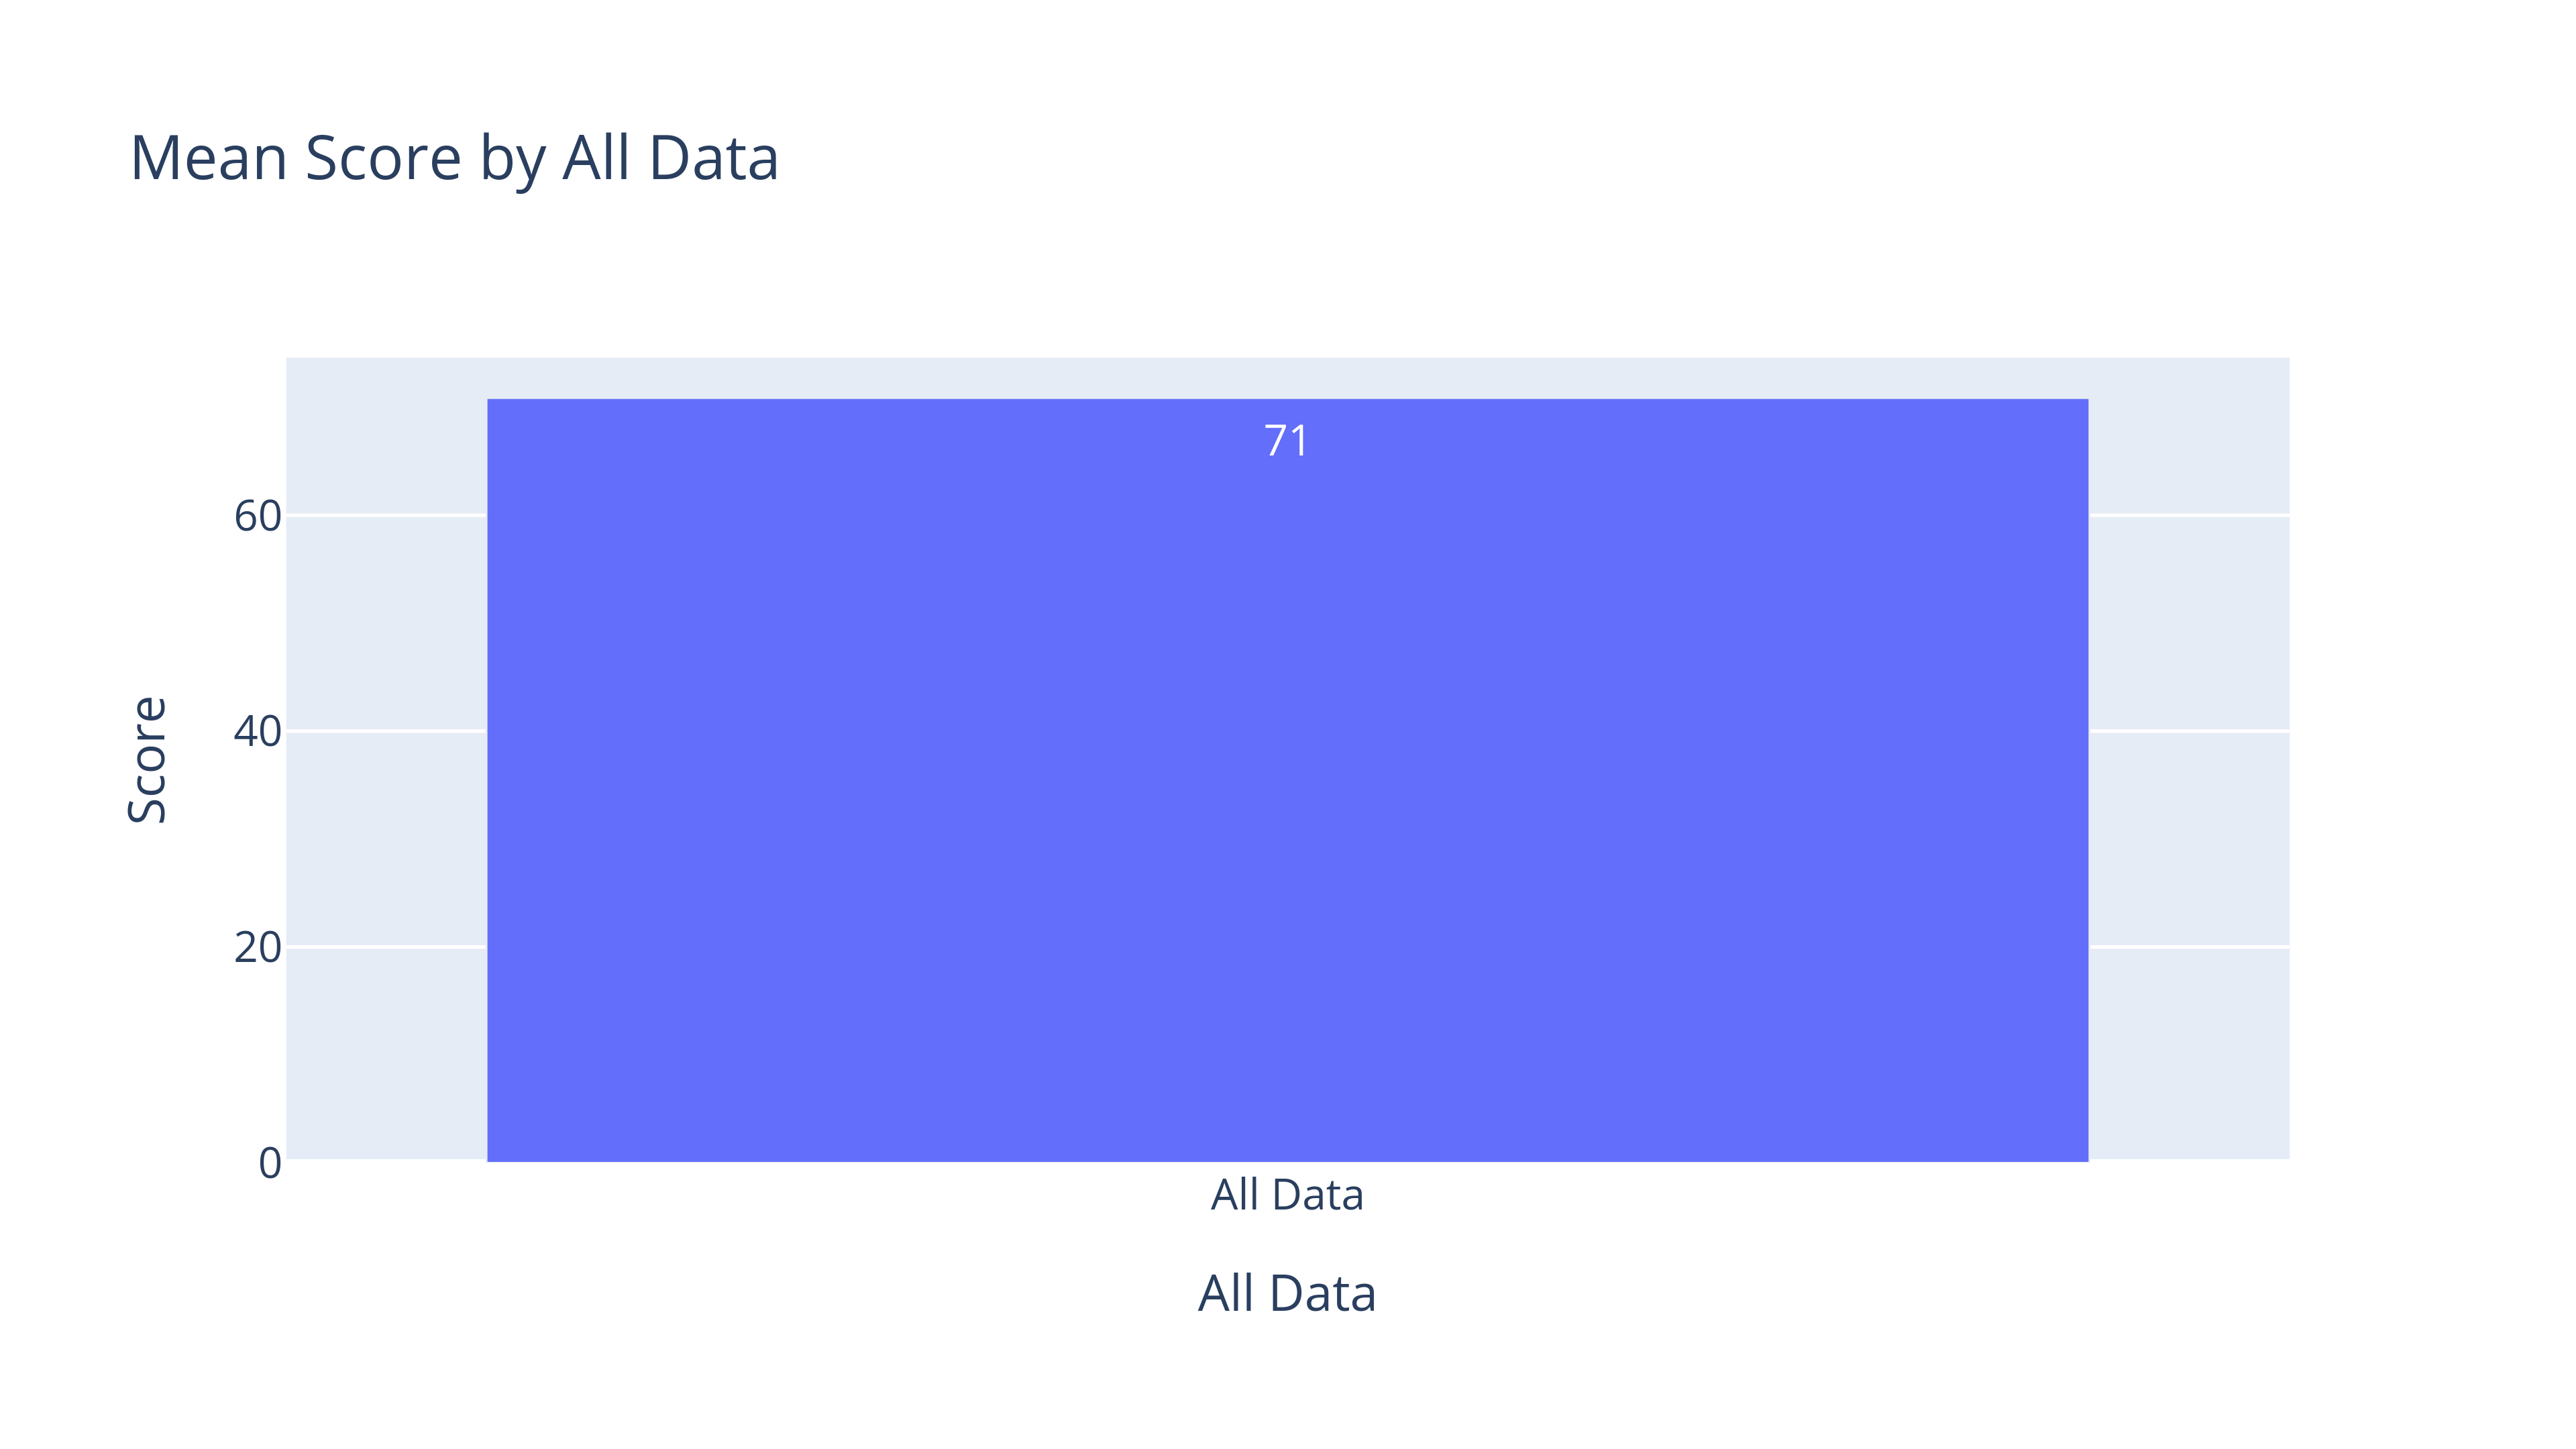

In [10]:
df_pivot, x_val_name, y, aggfunc = autopivot_simple(
    df_se, y = 'Score', aggfunc = 'mean', x_vars = [])

fig = autobar_simple(
    df_pivot = df_pivot, x_val_name = x_val_name, y = y, aggfunc = aggfunc
    )                      

wadi(fig=fig, file_path='output/mean_score_by_all_data',
    display_type=display_type)

The above examples demonstrate how the autopivot_simple and autobar_simple functions can work together to generate all sorts of different table and chart combinations, thus eliminating the need to write pivot table and bar chart code for each set of comparison variables a user might want to analyze. 

However, the charts they work together to produce leave much to be desired. There are no colors: the titles could use some work; and levels are sorted alphabetically rather than chronologically. Therefore, we'll now import more robust versions of these functions.

## Importing autopivot and autobar functions 

These functions are stored within the auto_pivot_and_graph.py file within the PFN_Dash_App_Demo component of PFN's Online Visualizations section. The Dash App Demo project applies them to automatically create new pivot tables--and corresponding charts--based on the input variables requested by dashboard visitors. 

I had originally kept a copy of these functions within this section as well, but that resulted in two redundant Python files that I would need to manually synchronize. Therefore, I decided to delete this section's copy and instead direct users to the Online Visualizations section if they needed to reference the code.

At this point, I *do* suggest that you take some time to look through the auto_pivot_and_graph.py file (see the following cell for assistance with locating it); it contains detailed commentary to help you understand what's going on within each step. 

In [11]:
sys.path.insert(2, '../Online_Visualizations/PFN_Dash_App_Demo')
from auto_pivot_and_graph import autopivot, autobar, autopivot_plus_bar

### Demonstrating these functions

First, here's a look at the output of autopivot() on its own:

In [12]:
(df_pivot, x_val_name, y, color, barmode, 
 x_var_count, index, aggfunc) = autopivot(
    df = df_se, y = 'Score', 
    x_vars = ['College', 'Level For Sorting', 'Level'], 
    color = 'Season', 
    x_vars_to_exclude = ['Level For Sorting', 'Season For Sorting'],
    aggfunc = 'mean')
print(x_val_name, y, color, barmode)
df_pivot.head(5)

x_vars: ['College', 'Level For Sorting', 'Level']
index prior to pivot_table() call: ['College', 'Level For Sorting', 'Level', 'Season']
College/Level Score Season group


College  Level For Sorting  ...      Score College/Level
0     STB                  0  ...  69.154329        STB/Fr
1     STB                  0  ...  68.543287        STB/Fr
2     STB                  1  ...  69.950769        STB/So
3     STB                  1  ...  64.950769        STB/So
4     STB                  2  ...  70.377306        STB/Ju

[5 rows x 6 columns]

And here's what autobar() produces when the above autopivot() output serves as its arguments:

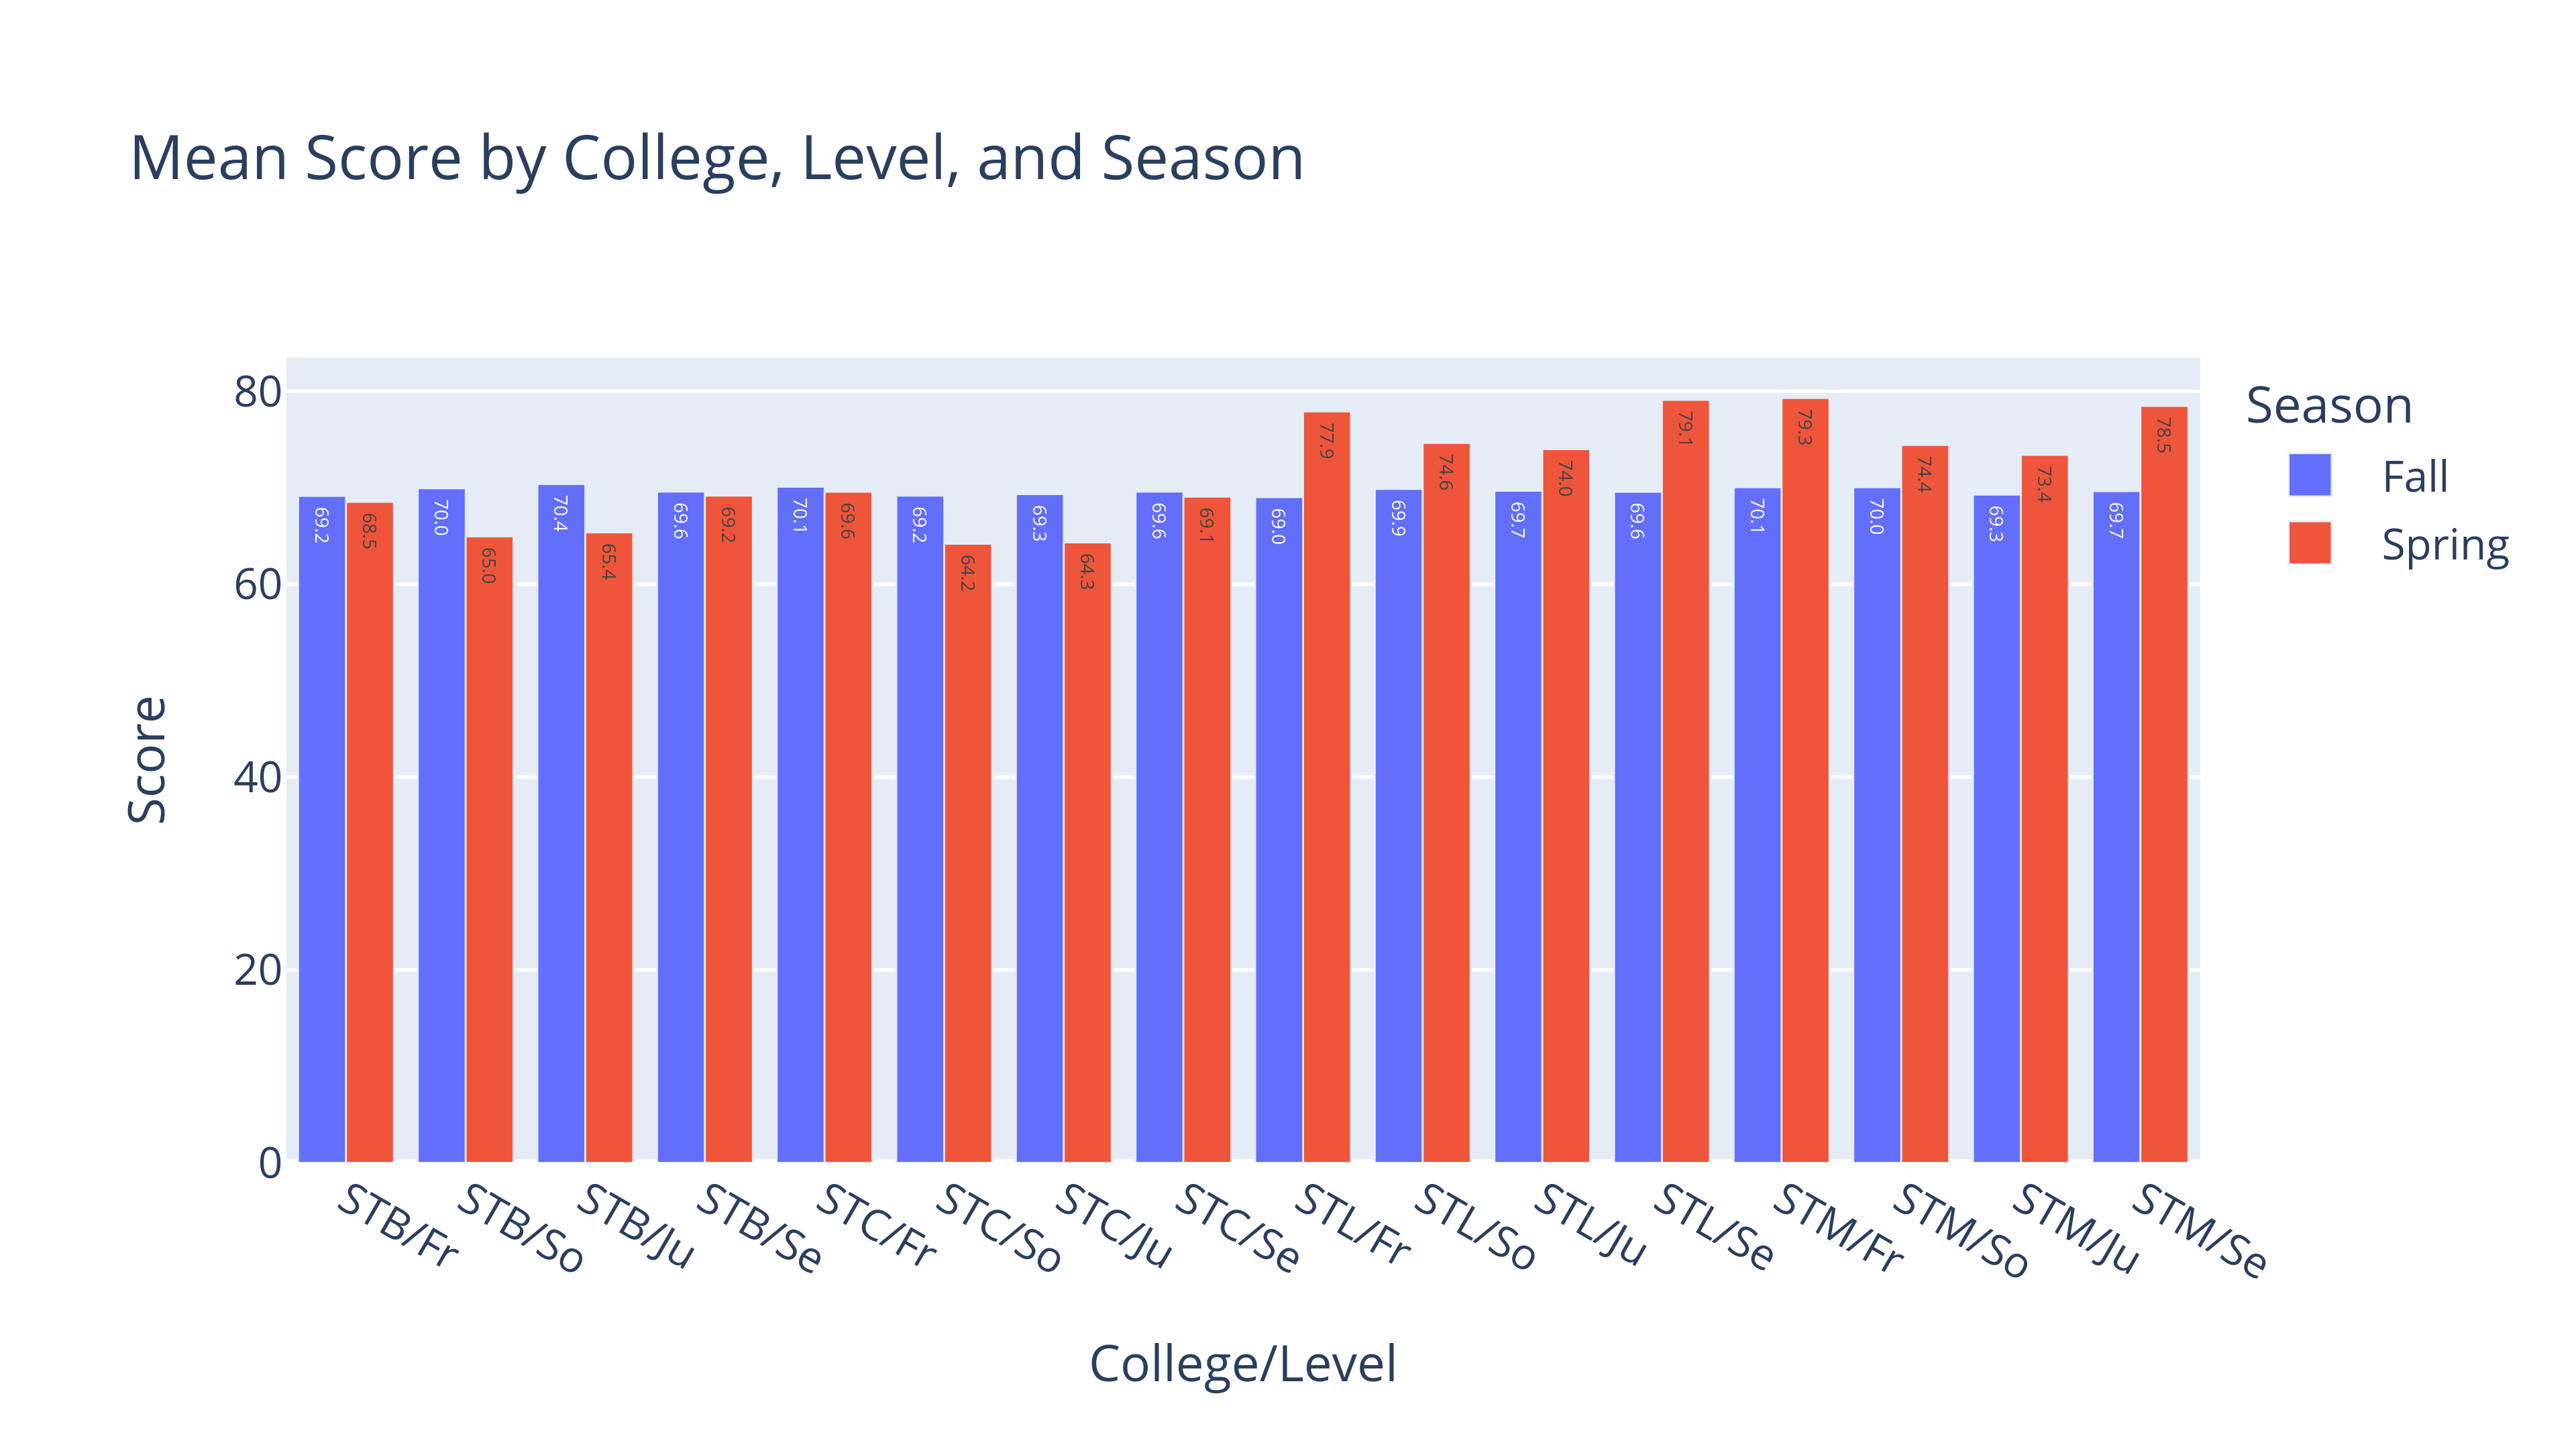

In [13]:
fig = autobar(
    df_pivot = df_pivot,
    x_val_name = x_val_name, y = y,
    color = color, barmode = barmode, 
    x_var_count = x_var_count, index = index,
    aggfunc = aggfunc)

wadi(fig=fig, 
     file_path='output/mean_score_by_college_level_and_season_autopivot',
     display_type=display_type)
                               

We can simplify this code even further by calling autopivot_plus_bar():

x_vars: ['College', 'Level For Sorting', 'Level']
index prior to pivot_table() call: ['College', 'Level For Sorting', 'Level', 'Season']


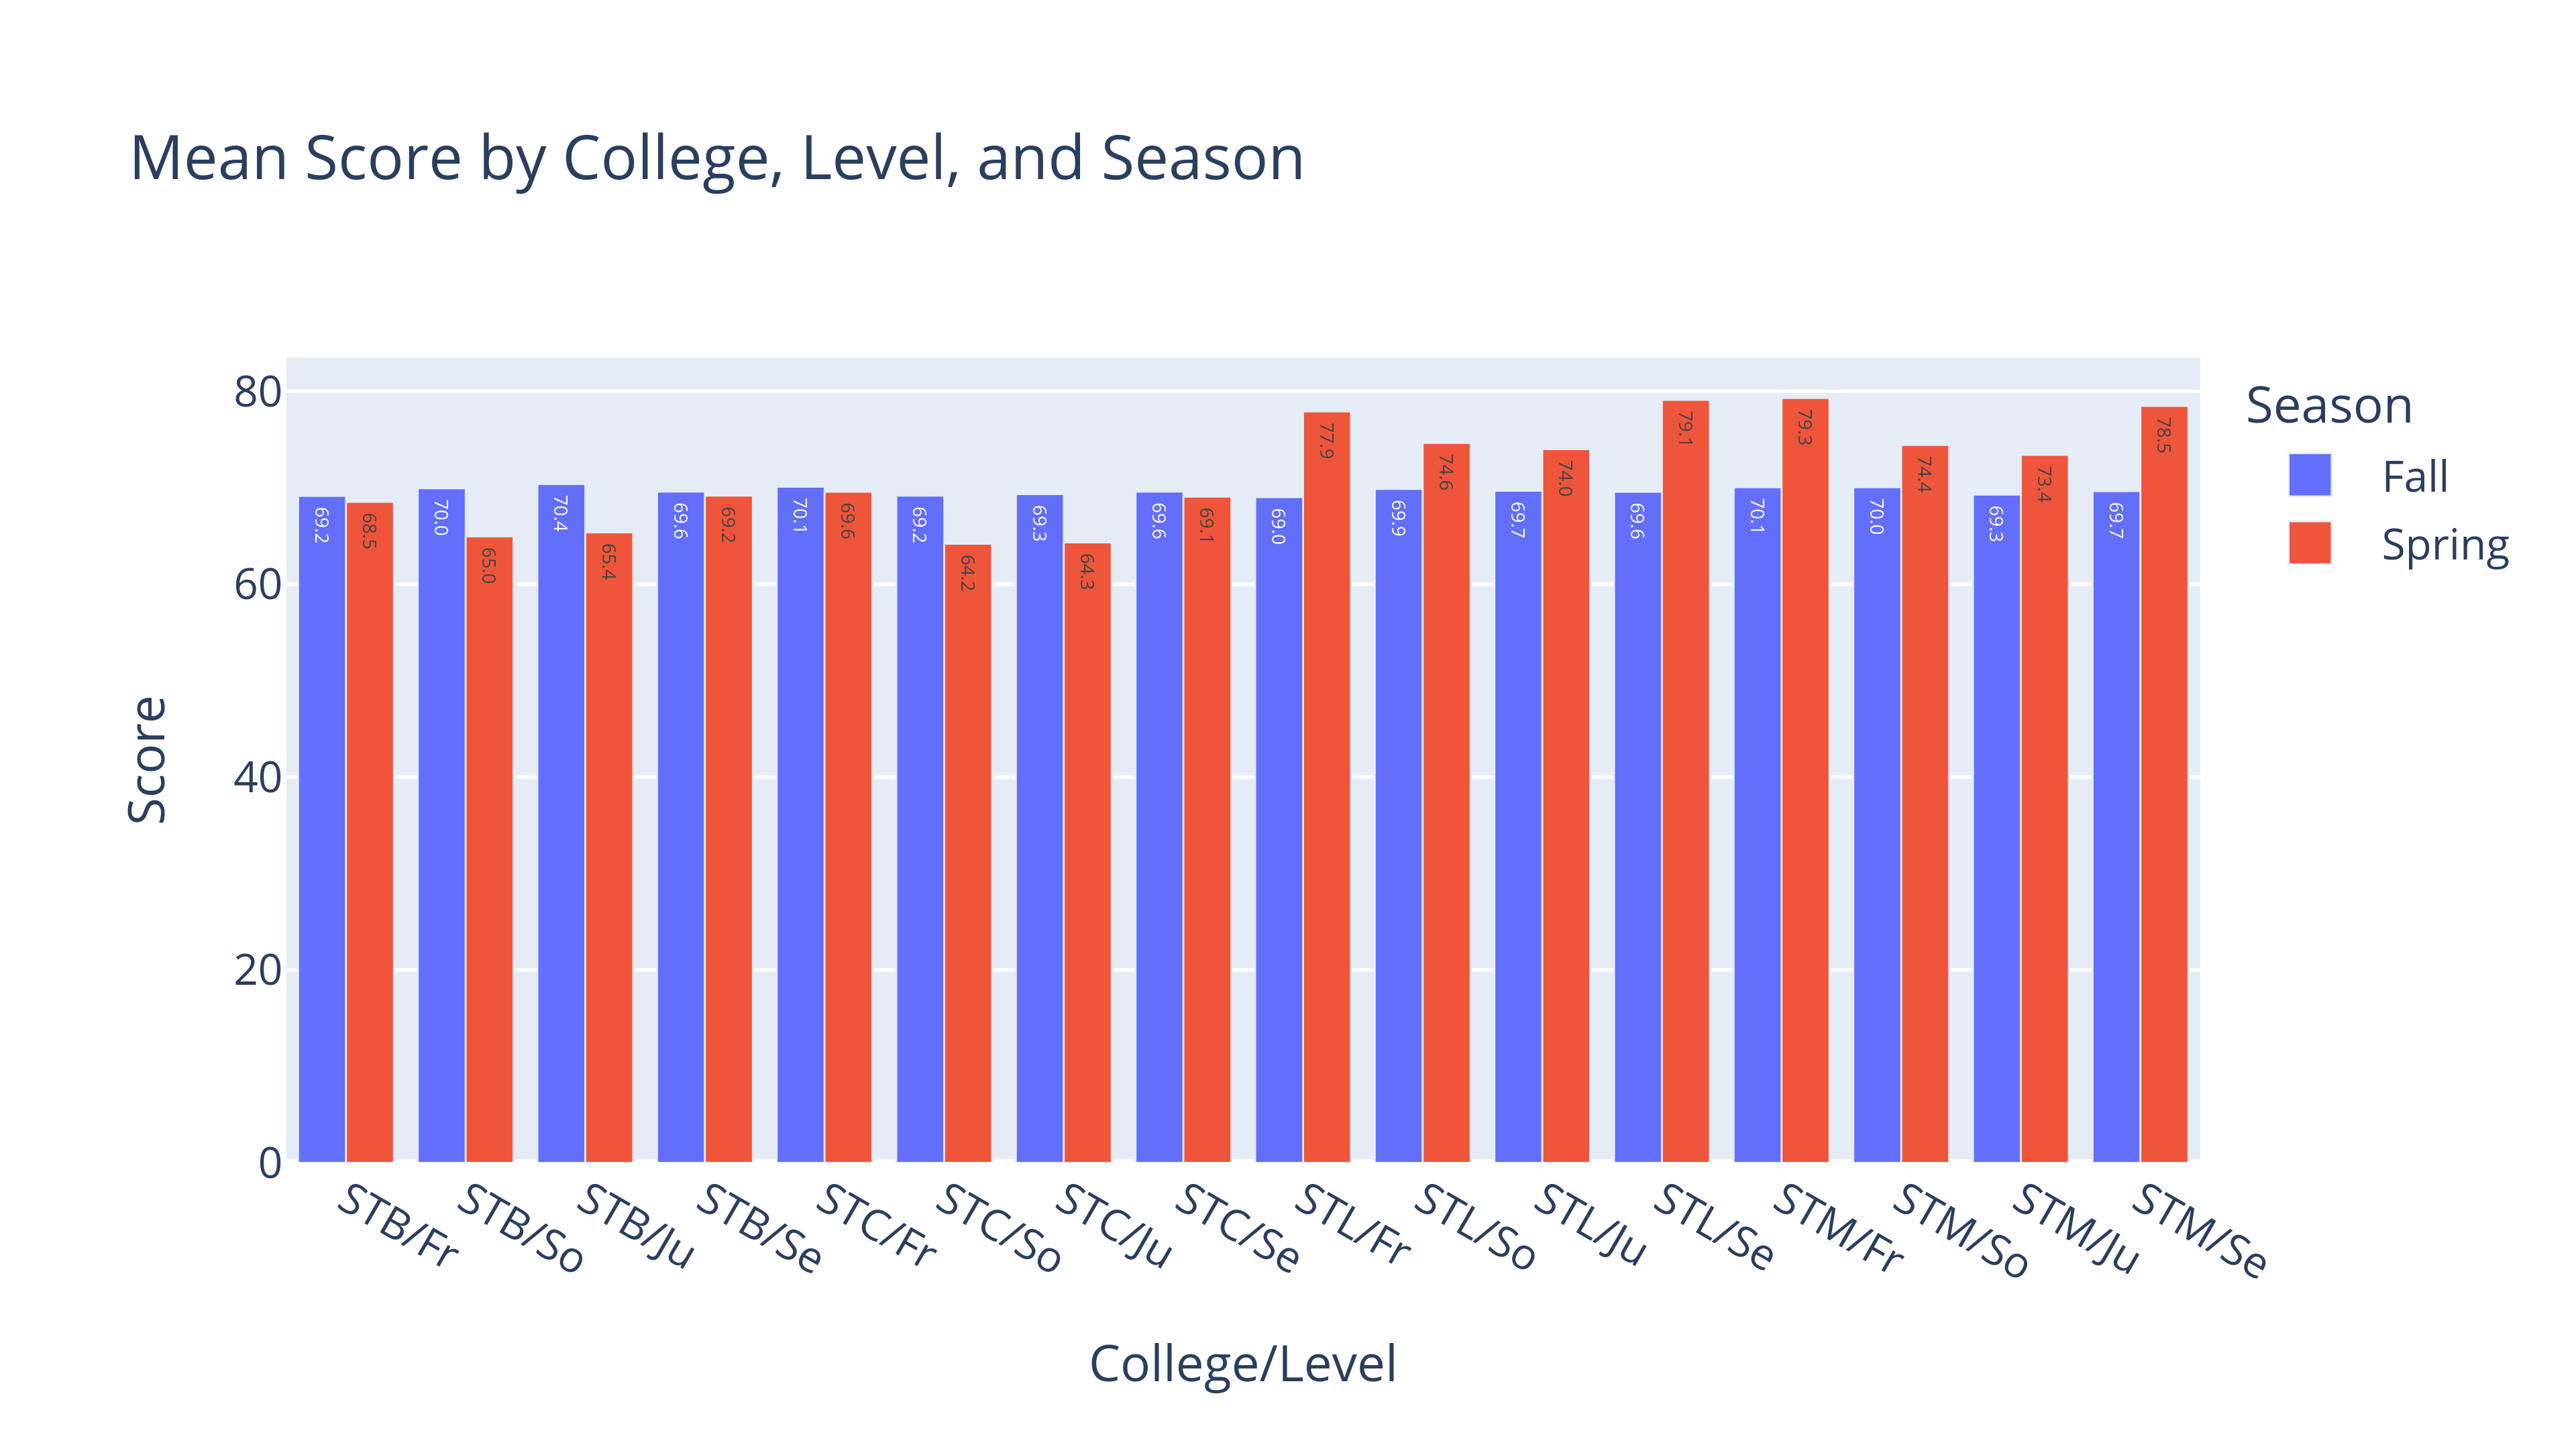

In [14]:
fig = autopivot_plus_bar(
    df = df_se, y = 'Score', 
    x_vars = ['College', 'Level For Sorting', 'Level'], 
    color = 'Season', 
    x_vars_to_exclude = ['Level For Sorting', 'Season For Sorting'],
    aggfunc = 'mean')

wadi(fig=fig, 
     file_path='output/mean_score_by_college_level_and_\
season_autopivot_v2', display_type=display_type)

Here's what the output looks like with 3 comparison variables:

x_vars: ['College', 'Level For Sorting', 'Level']
index prior to pivot_table() call: ['College', 'Level For Sorting', 'Level', 'Season']
College/Level Score Season group
  College  Level For Sorting  ...      Score College/Level
0     STB                  0  ...  69.154329        STB/Fr
1     STB                  0  ...  68.543287        STB/Fr
2     STB                  1  ...  69.950769        STB/So
3     STB                  1  ...  64.950769        STB/So
4     STB                  2  ...  70.377306        STB/Ju

[5 rows x 8 columns]


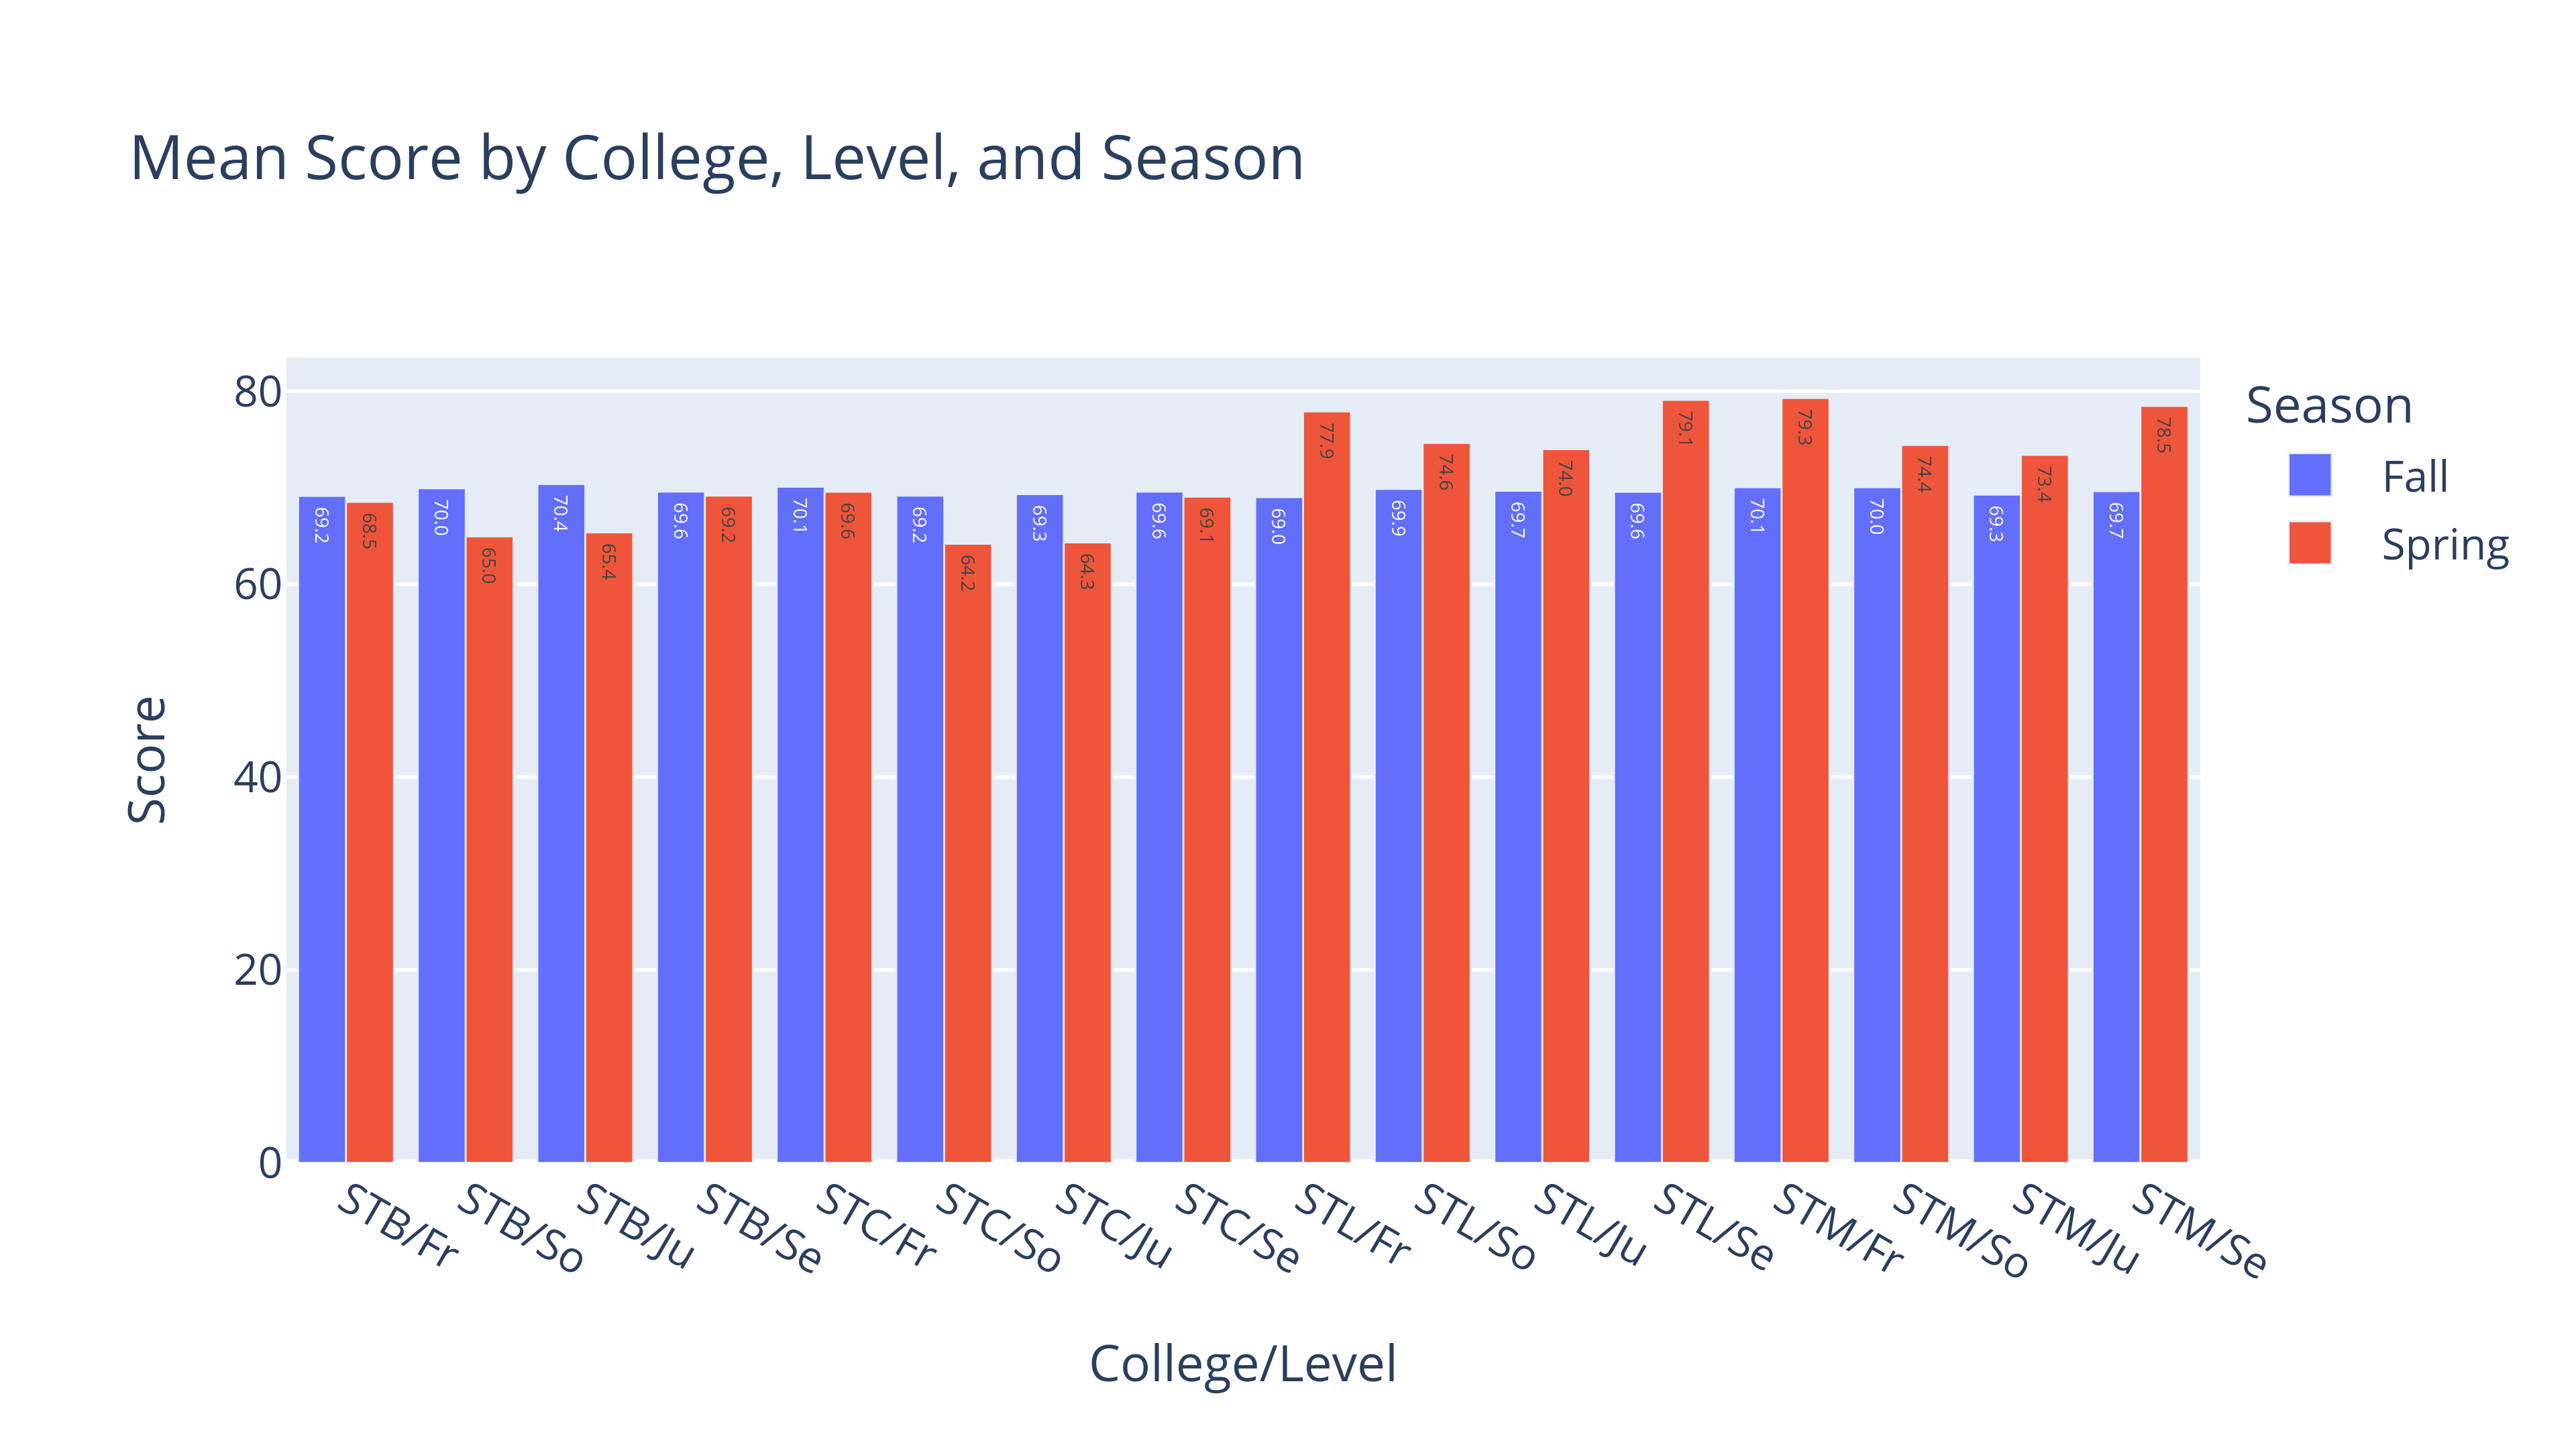

In [15]:
(df_pivot, x_val_name, y, color, barmode, 
 x_var_count, index, aggfunc) = autopivot(
    df = df_se_pivot, y = 'Score', 
    x_vars = ['College', 'Level For Sorting', 'Level'], 
    color = 'Season', 
    x_vars_to_exclude = ['Level For Sorting', 'Season For Sorting'],
    aggfunc = 'mean', weight_col = 'Responses')
print(x_val_name, y, color, barmode)
print(df_pivot.head(5))

fig = autobar(
    df_pivot = df_pivot,
    x_val_name = x_val_name, y = y,
    color = color, barmode = barmode, 
    x_var_count = x_var_count, index = index,
    aggfunc = aggfunc)

wadi(fig=fig, 
     file_path='output/mean_score_by_college_level_and_\
season_autopivot_v3', display_type=display_type)
                               

Here's a chart with just 2 comparison variables:

x_vars: ['Level', 'Season For Sorting']
index prior to pivot_table() call: ['Level', 'Season For Sorting', 'Season']


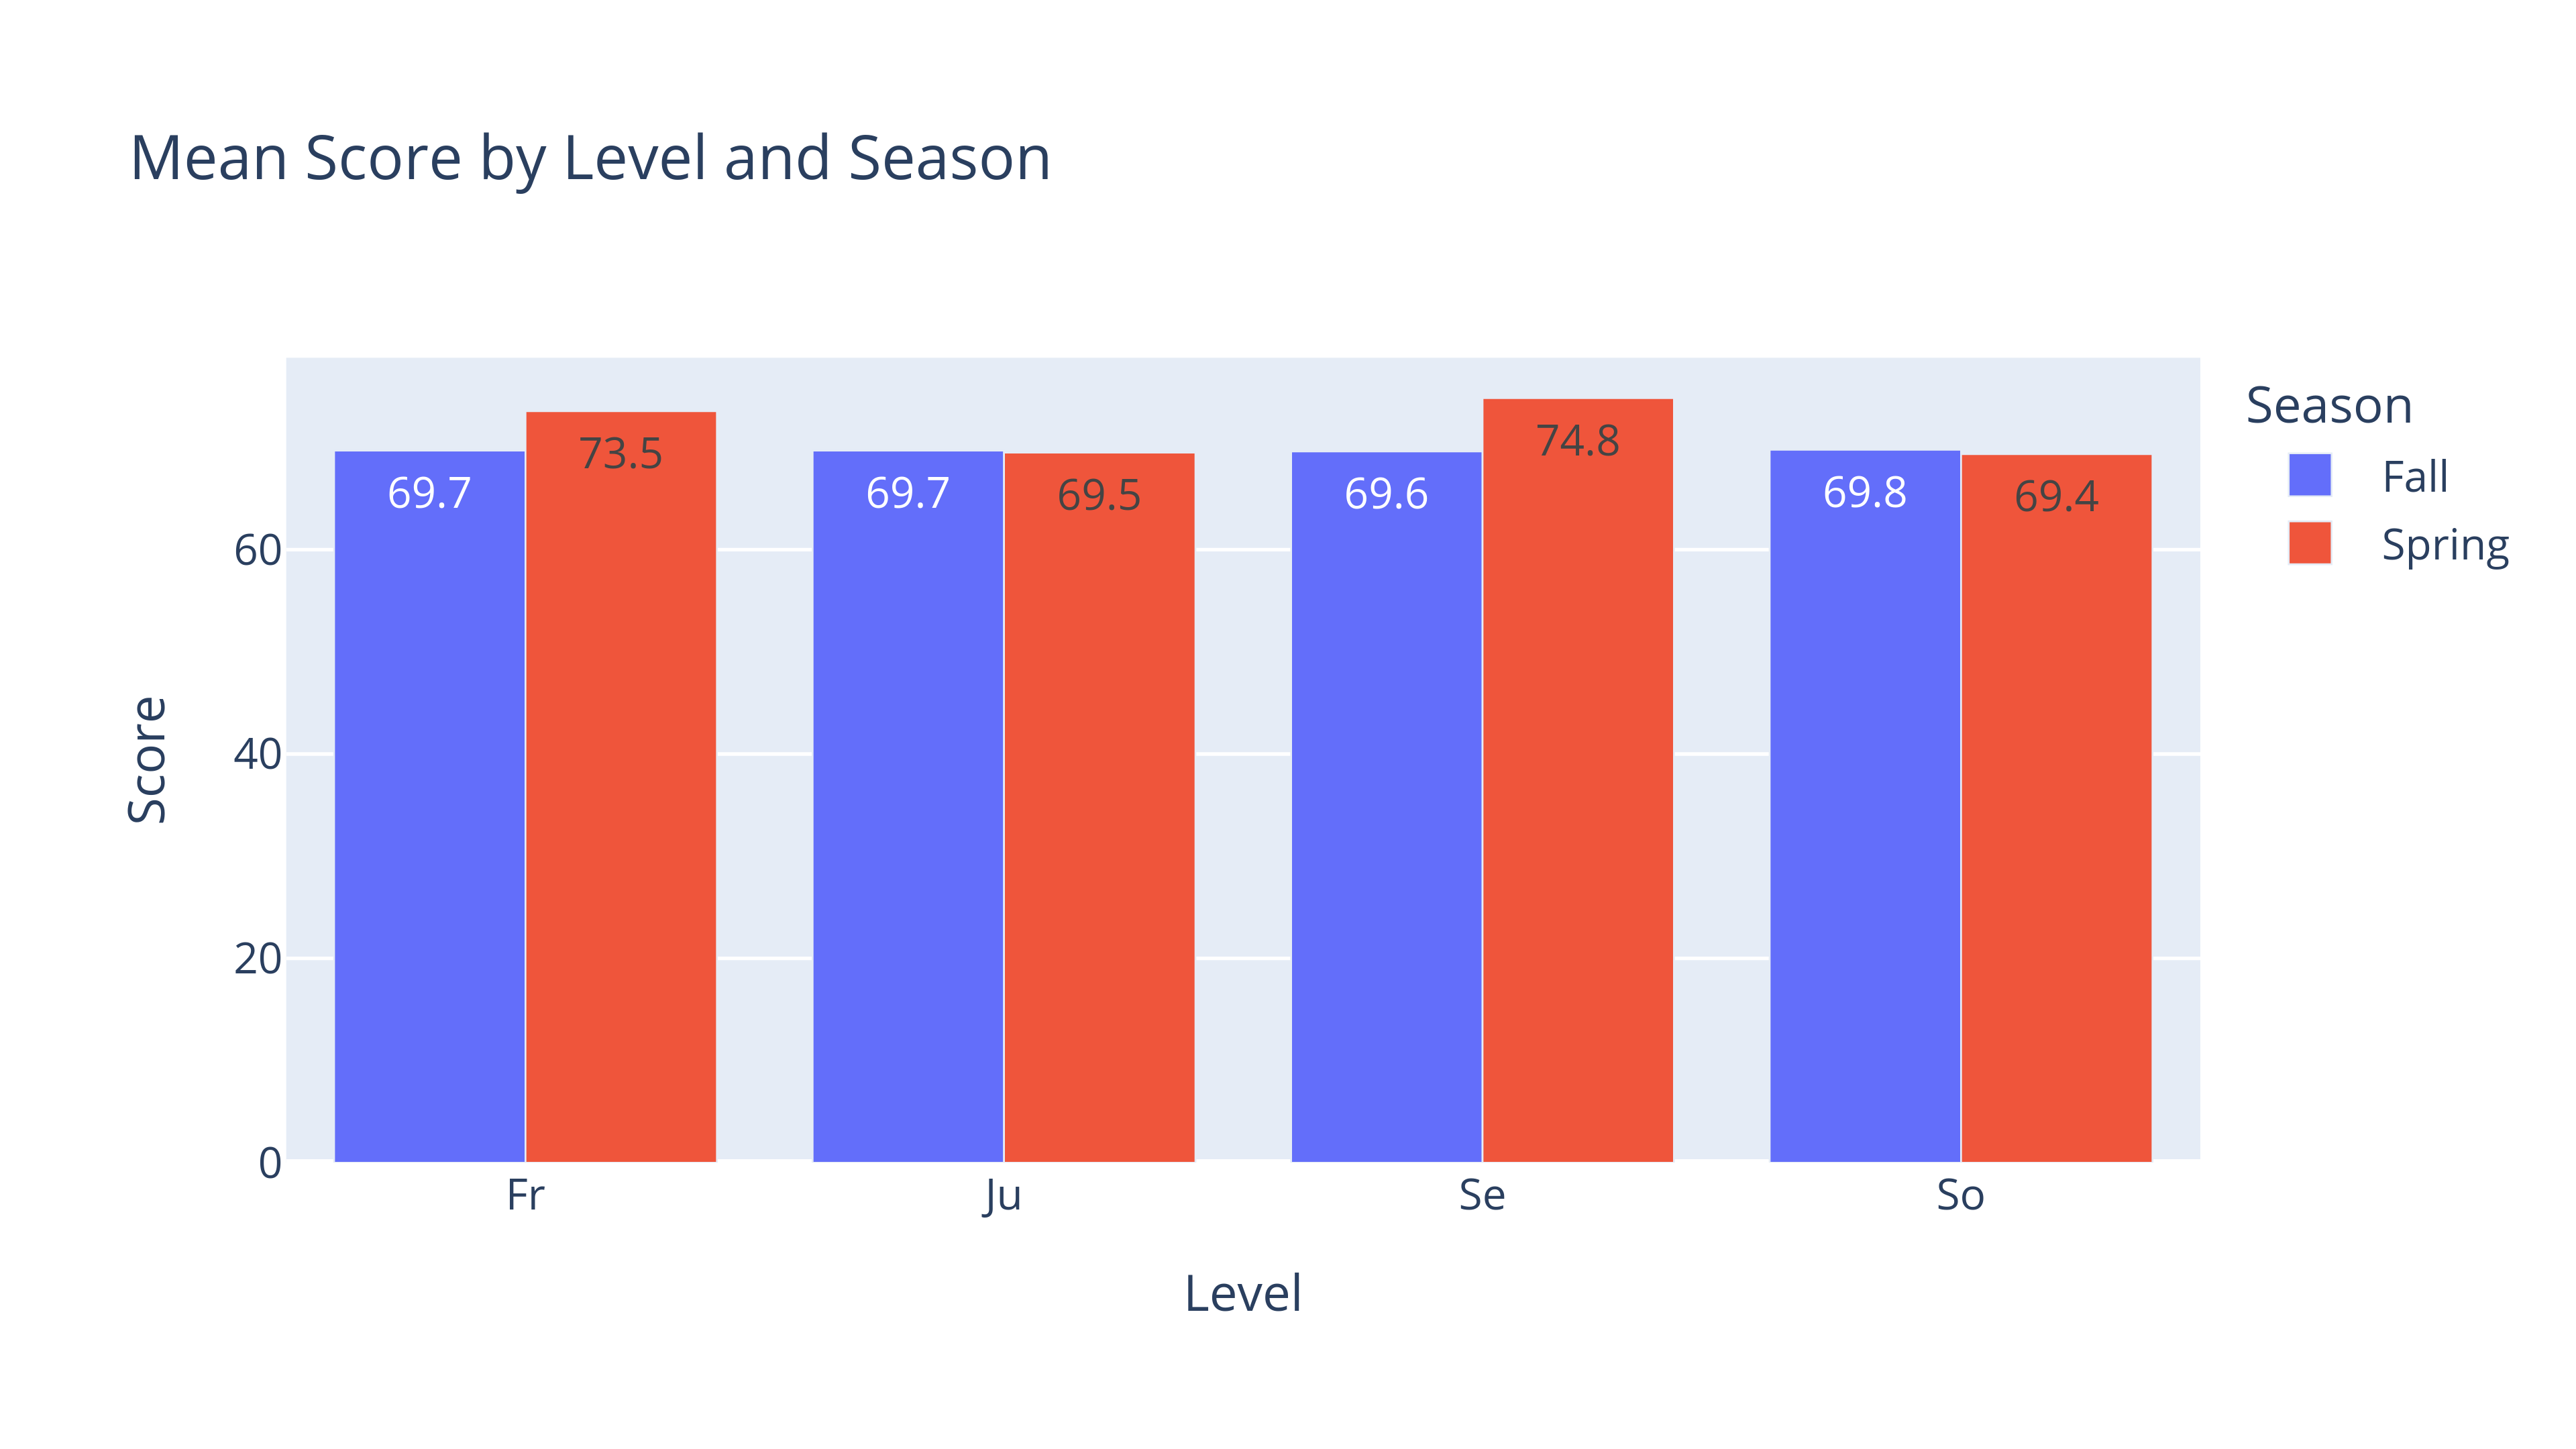

In [16]:
fig = autopivot_plus_bar(
    df = df_se, y = 'Score', 
    x_vars = ['Level', 'Season For Sorting'], 
    color = 'Season', 
    x_vars_to_exclude = ['Season For Sorting'],
    aggfunc = 'mean')

wadi(fig=fig, 
     file_path='output/mean_score_by_level_and_season_autopivot', 
     display_type=display_type)

Note that the above output is identical to the output of the following cell, which uses an aggregated dataframe (df_se_pivot) as its data source. This identical output was achieved by adding in a weight column ('Respones').

x_vars: ['Level']
index prior to pivot_table() call: ['Level', 'Season']


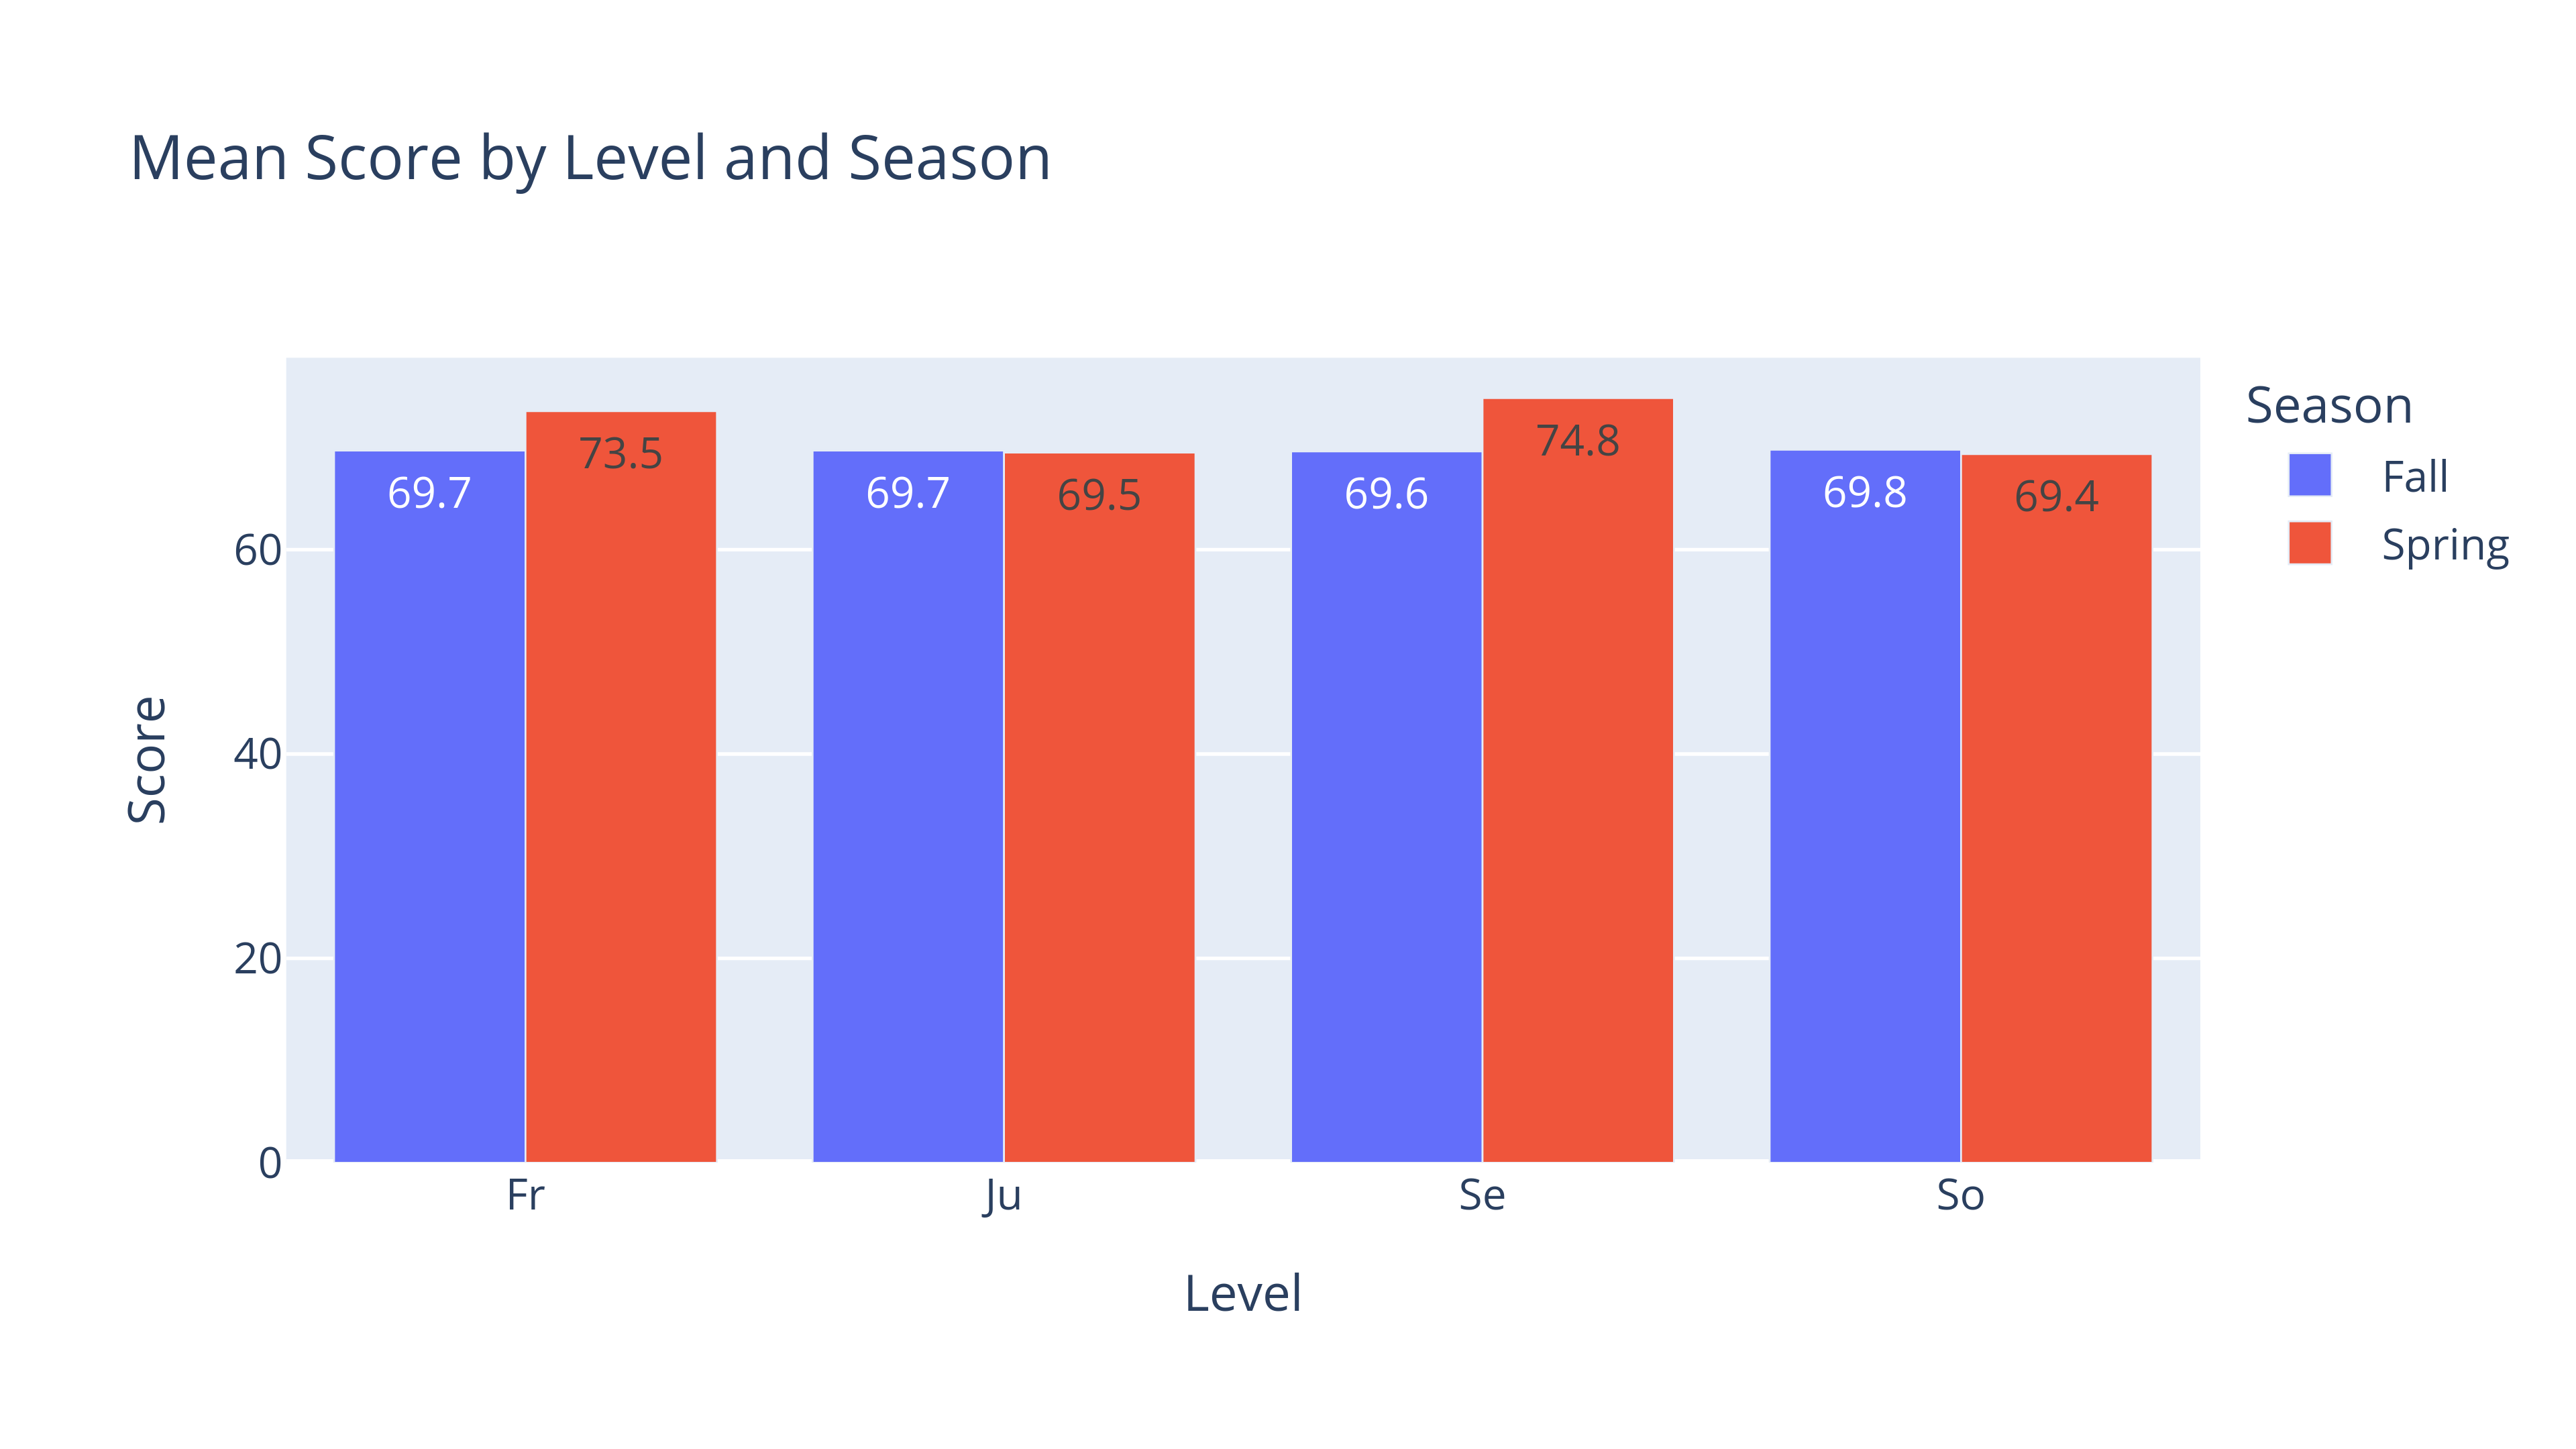

In [17]:
fig = autopivot_plus_bar(
    df = df_se_pivot, y = 'Score', 
    x_vars = ['Level'], 
    color = 'Season', 
    x_vars_to_exclude = ['Season For Sorting'],
    aggfunc = 'mean', weight_col = 'Responses')        

wadi(fig=fig, 
     file_path='output/mean_score_by_level_and_season_autopivot_v2', 
     display_type=display_type)

In contrast, the following output, which uses df_se_pivot as well but does *not* reference a weight column, differs slightly from the above two graphs. This is because it is falling into the 'average of averages' error noted earlier.

x_vars: ['Level']
index prior to pivot_table() call: ['Level', 'Season']


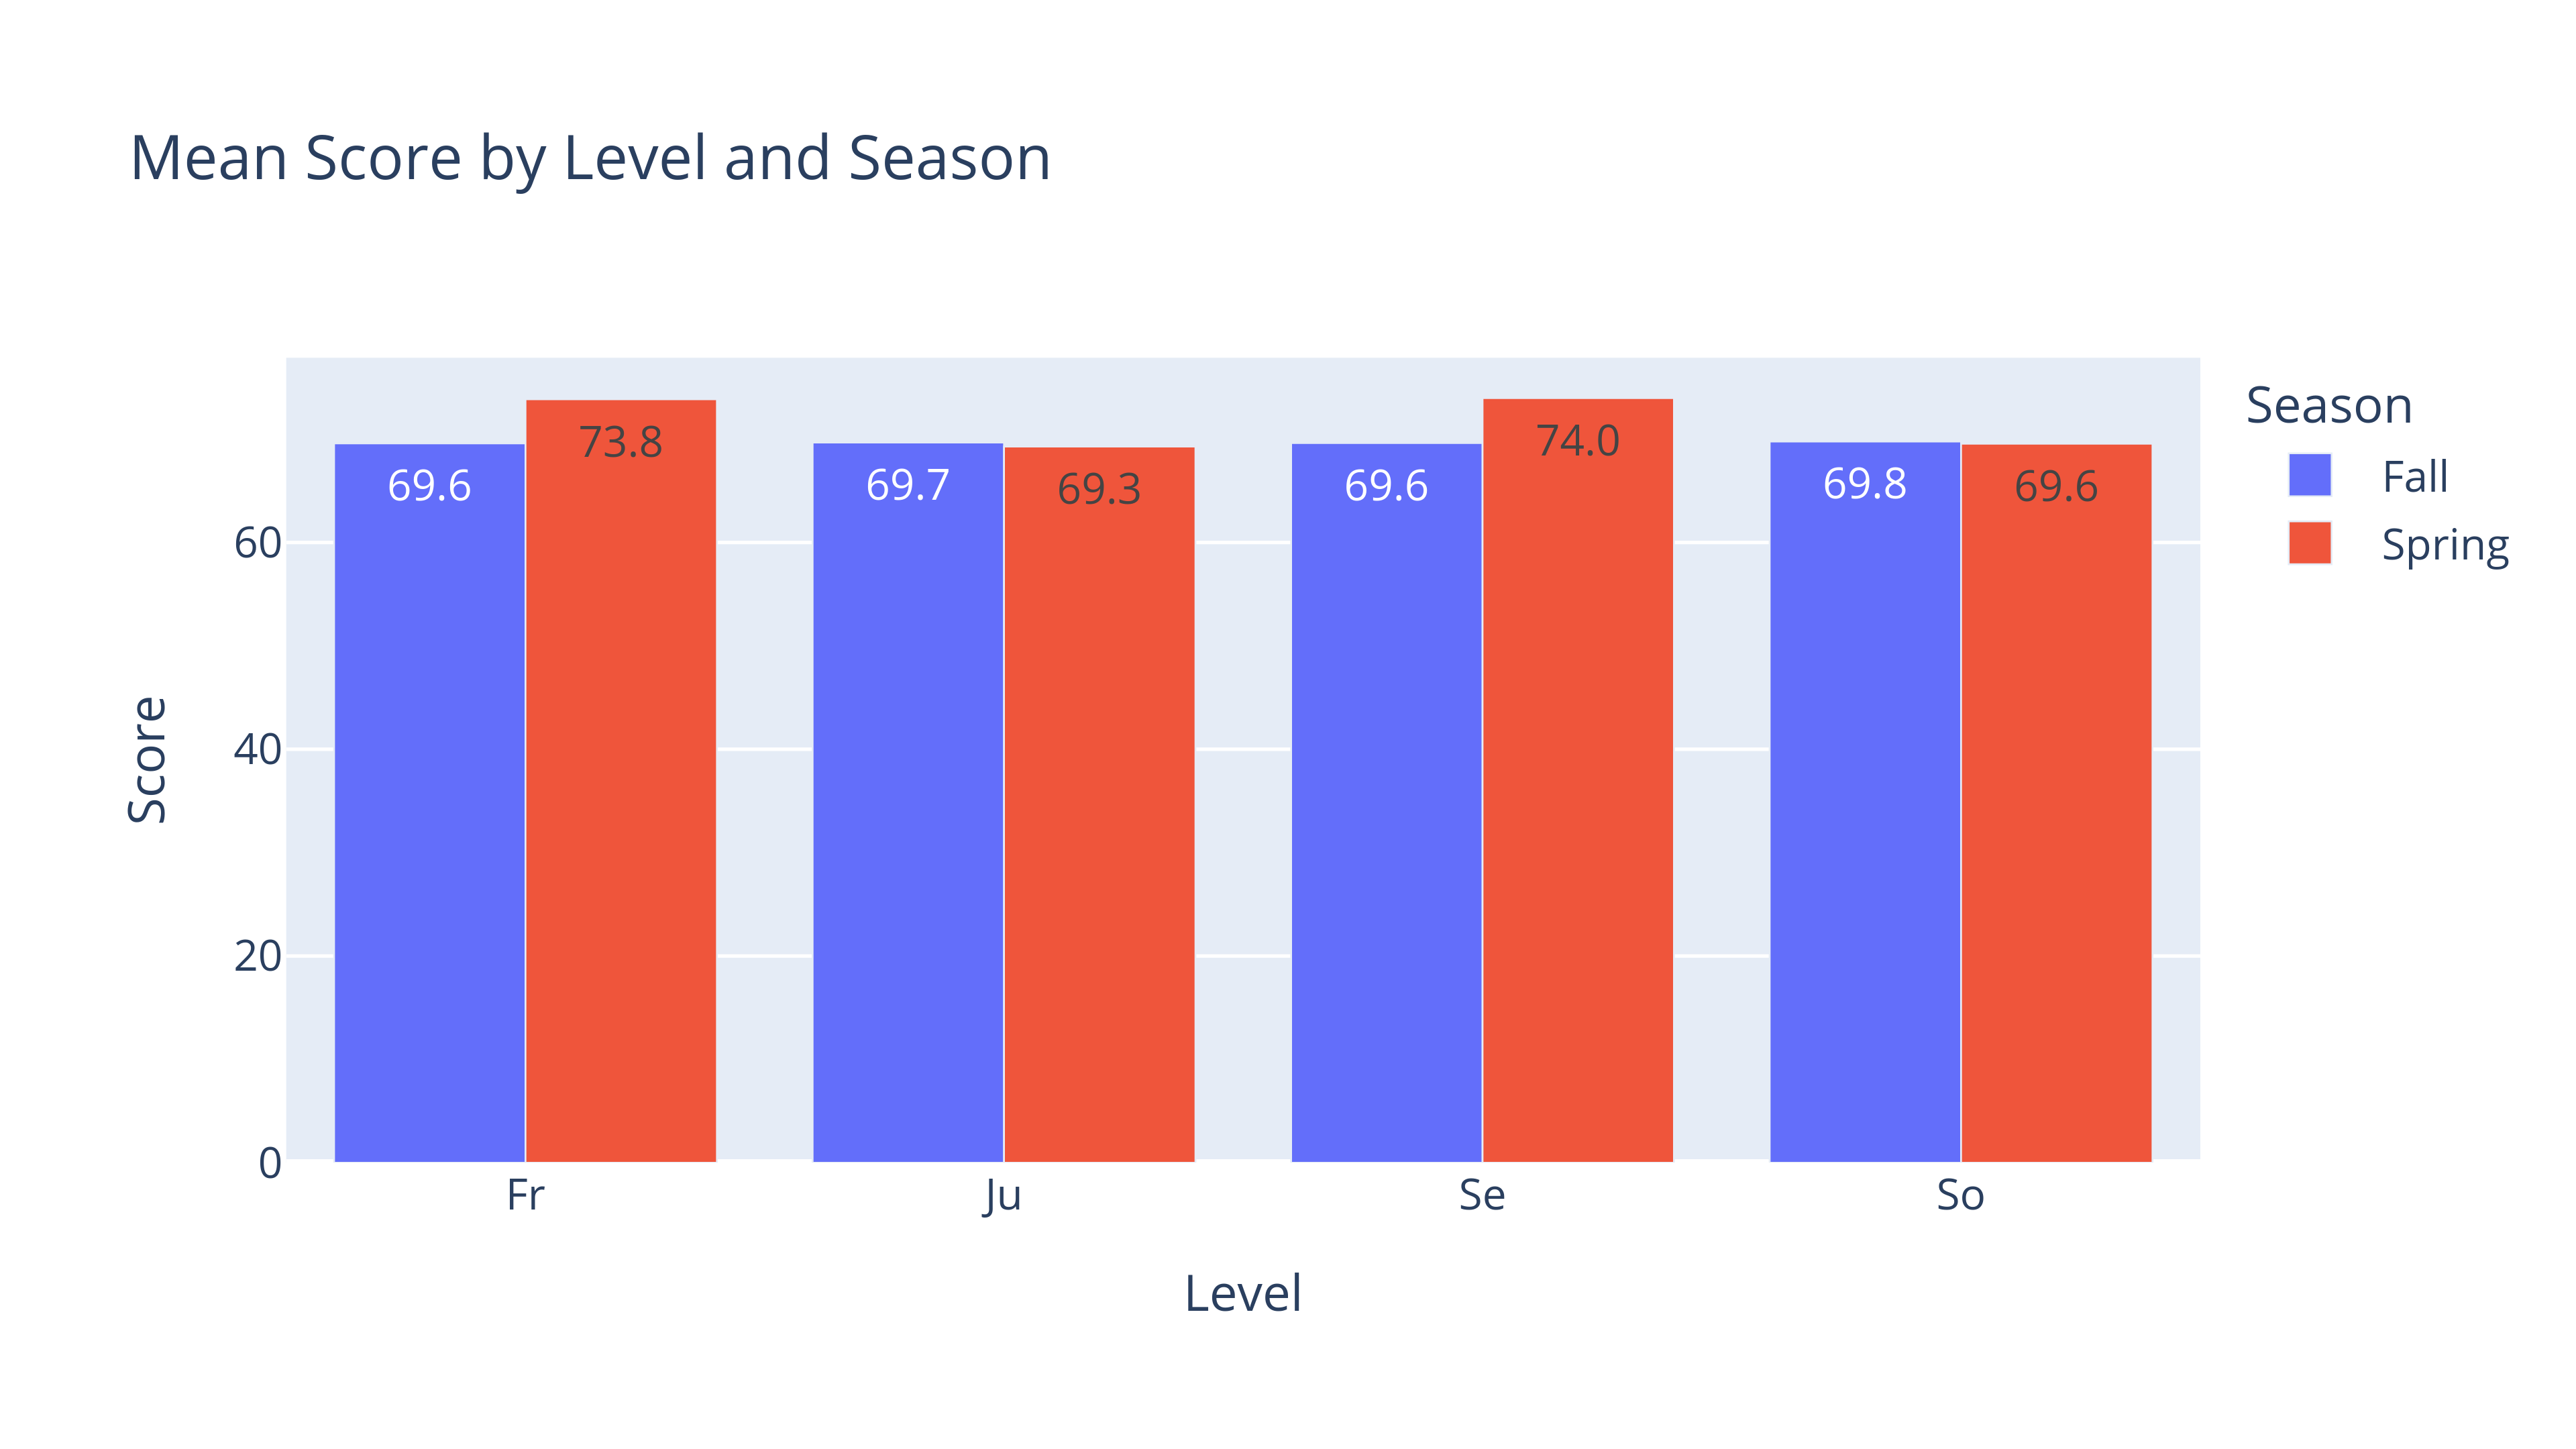

In [18]:
fig = autopivot_plus_bar(
    df = df_se_pivot, y = 'Score', 
    x_vars = ['Level'], 
    color = 'Season', 
    x_vars_to_exclude = ['Season For Sorting'],
    aggfunc = 'mean')    

wadi(fig=fig, 
     file_path='output/mean_score_by_level_and_season_autopivot_aoa_error', 
     display_type=display_type)

These functions also allow the color argument to be skipped, though the result is rather plain:

x_vars: ['College', 'Level']
index prior to pivot_table() call: ['College', 'Level']


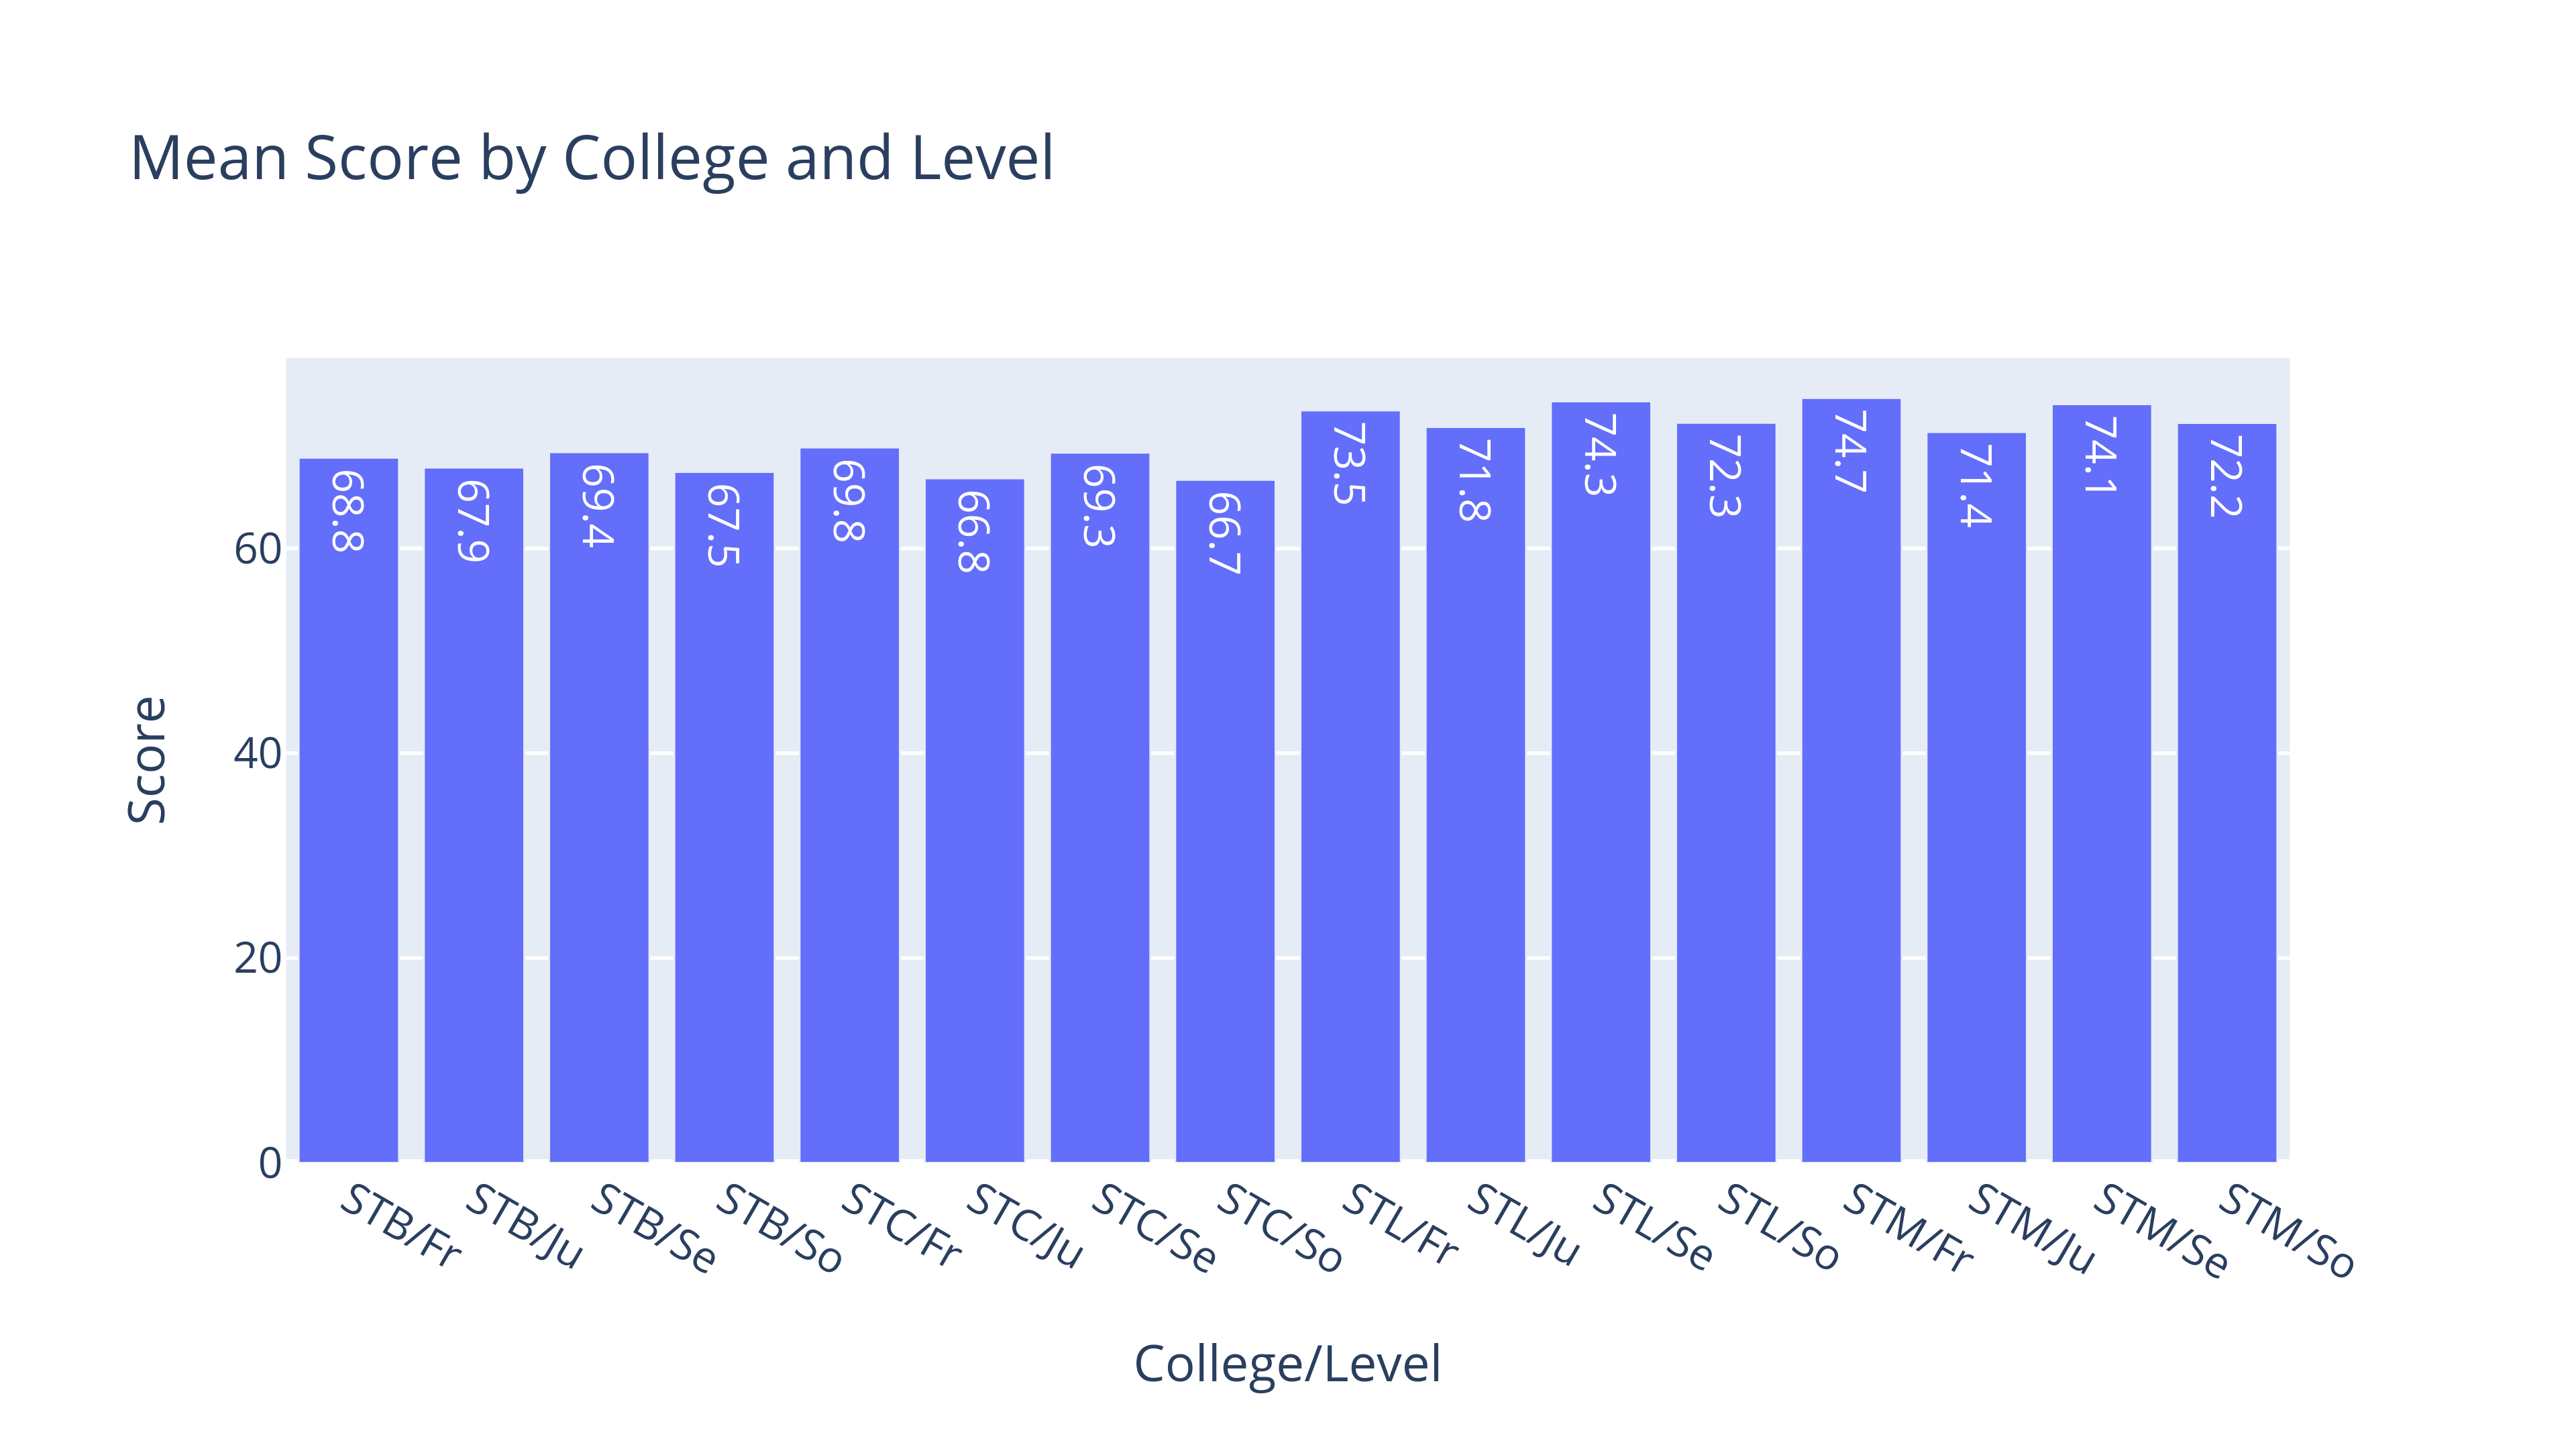

In [19]:
fig = autopivot_plus_bar(
    df = df_se, y = 'Score', 
    x_vars = ['College', 'Level'],
    aggfunc = 'mean')

wadi(fig=fig, 
     file_path='output/mean_score_by_college_and_level_autopivot_colorless', 
     display_type=display_type)

They also allow an empty list of comparison values to get passed to x_vars, thus producing a single bar that represents the average of all values in the DataFrame.

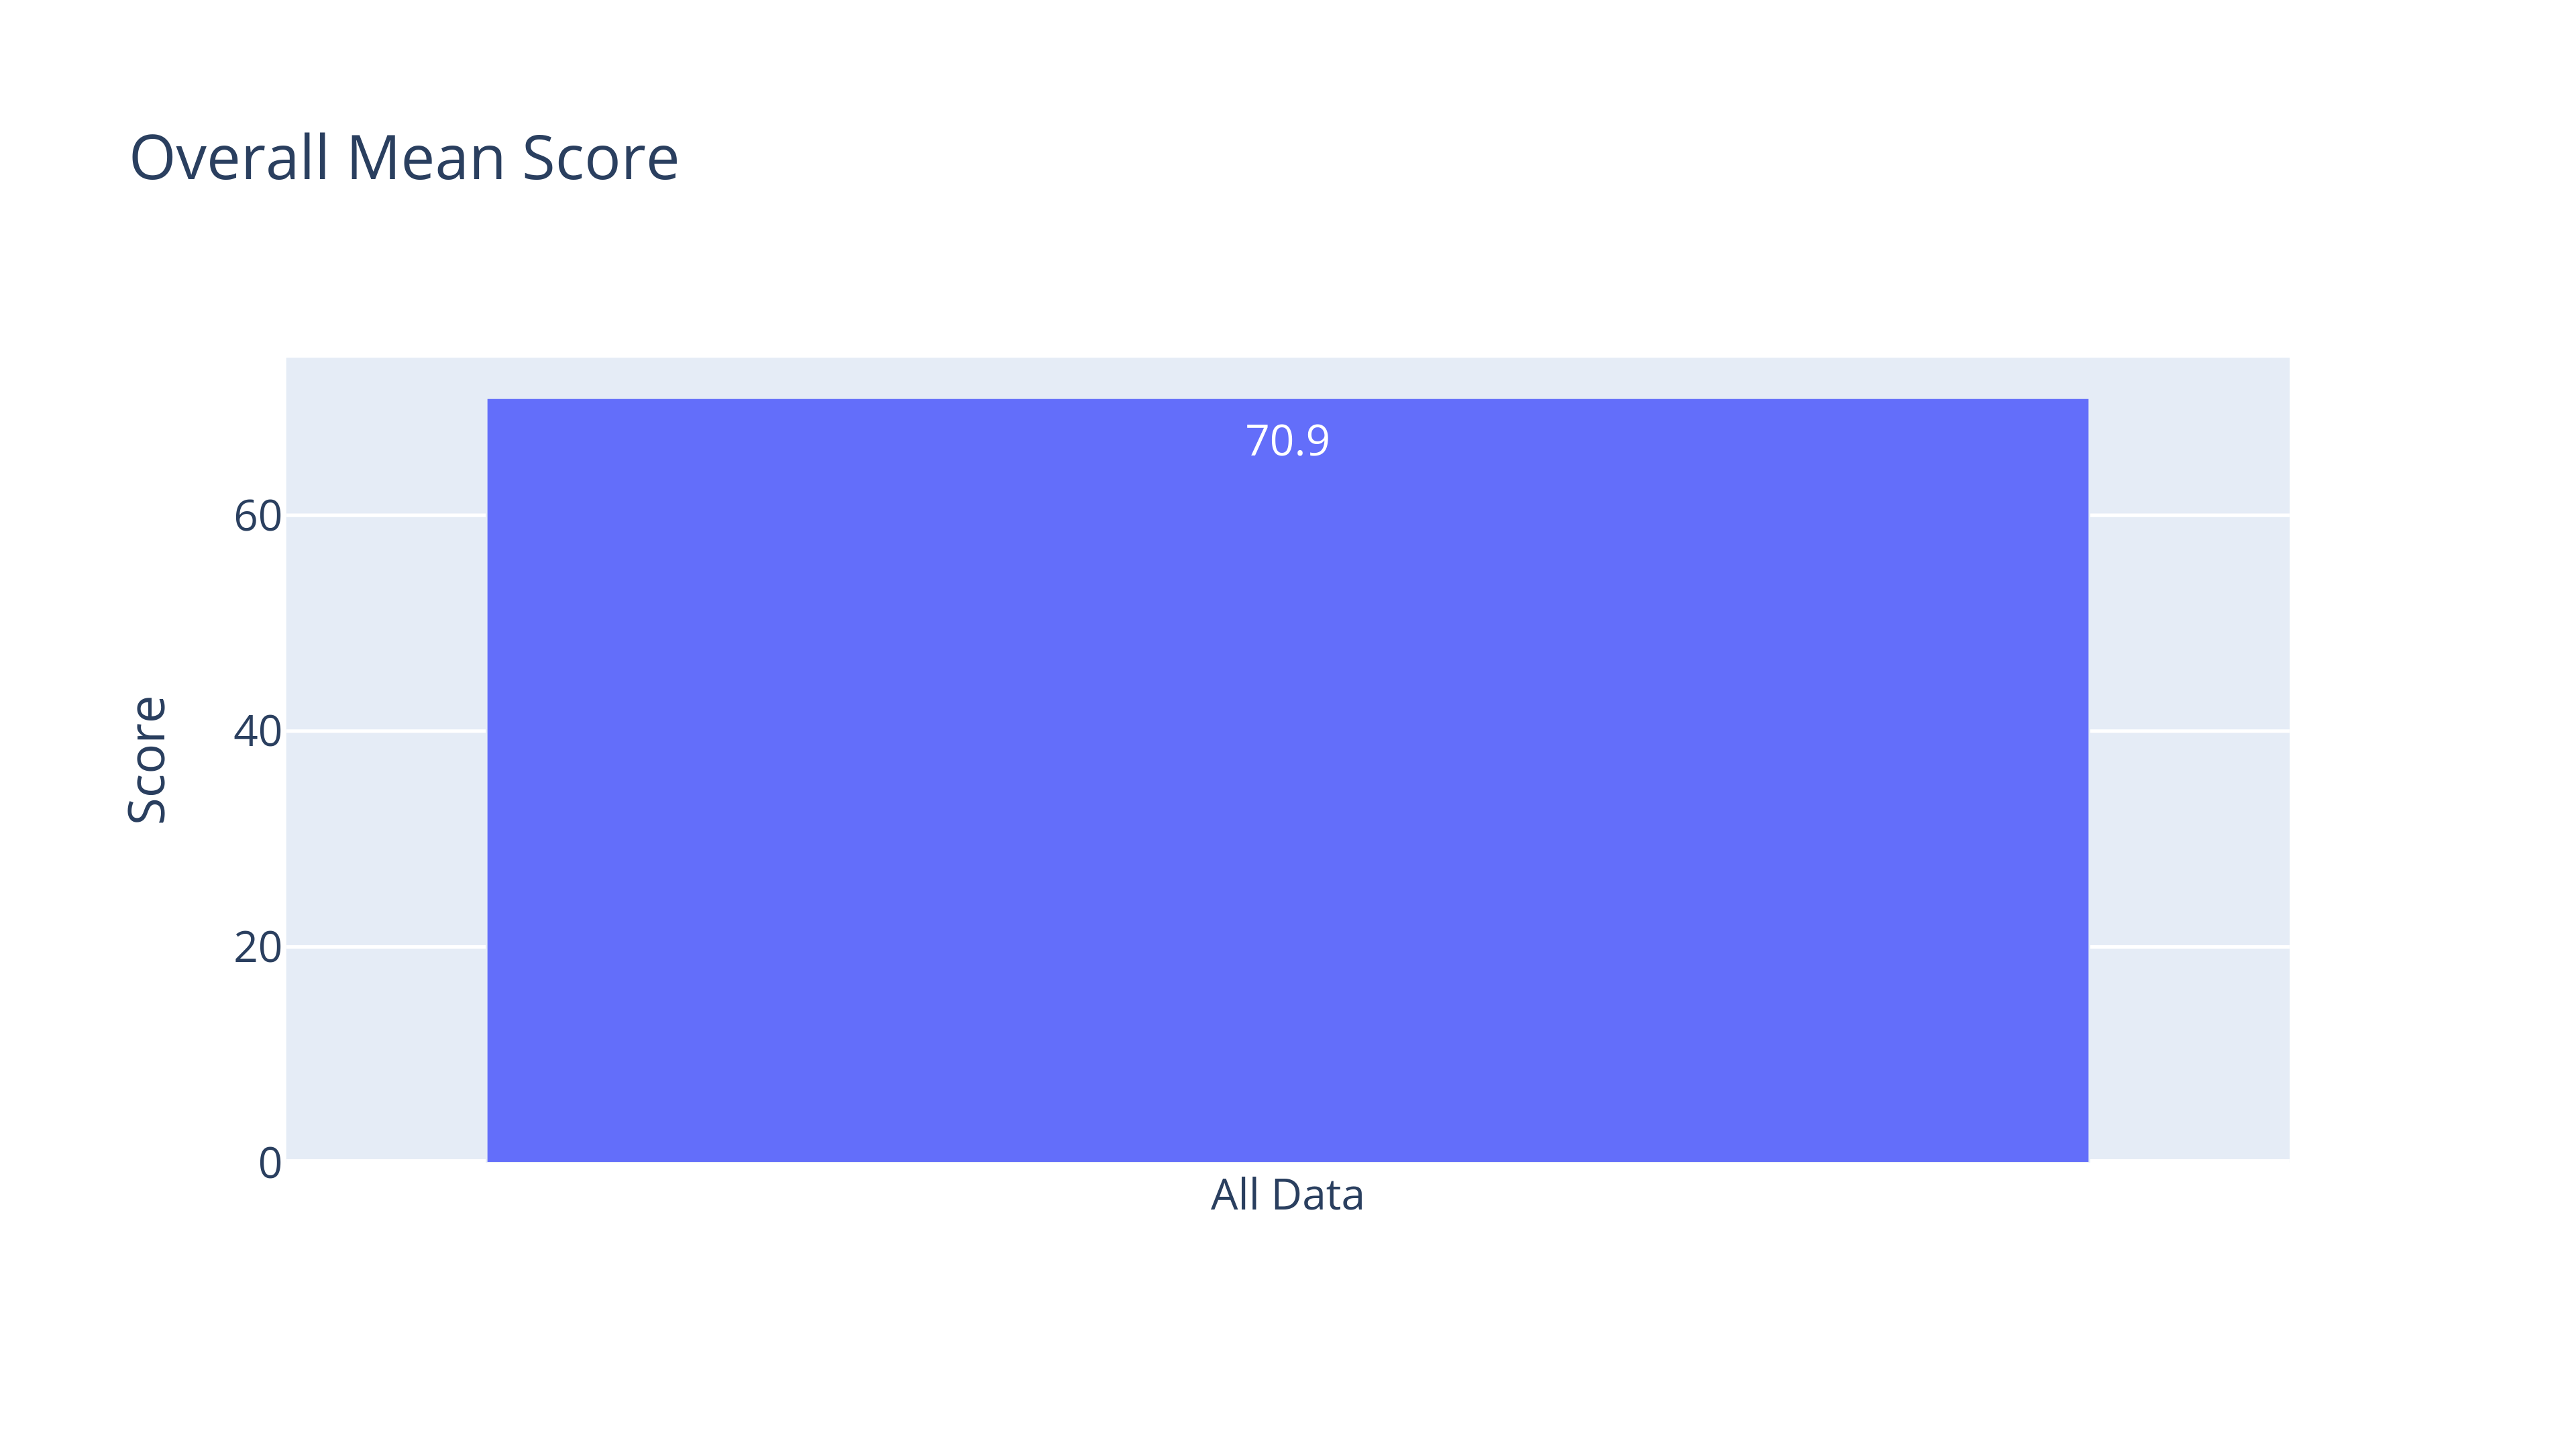

In [20]:
fig = autopivot_plus_bar(
    df = df_se, y = 'Score', 
    x_vars = [], 
    color = None, 
    x_vars_to_exclude = [],
    aggfunc = 'mean')       

wadi(fig=fig, 
     file_path='output/overall_mean_score_autopivot', 
     display_type=display_type)

At the opposite extreme, we can graph 6 comparison variables within the same chart (though the result is not the easiest to read):

x_vars: ['Starting Year', 'Gender', 'College', 'Class Of', 'Level For Sorting', 'Level']
index prior to pivot_table() call: ['Starting Year', 'Gender', 'College', 'Class Of', 'Level For Sorting', 'Level', 'Season']


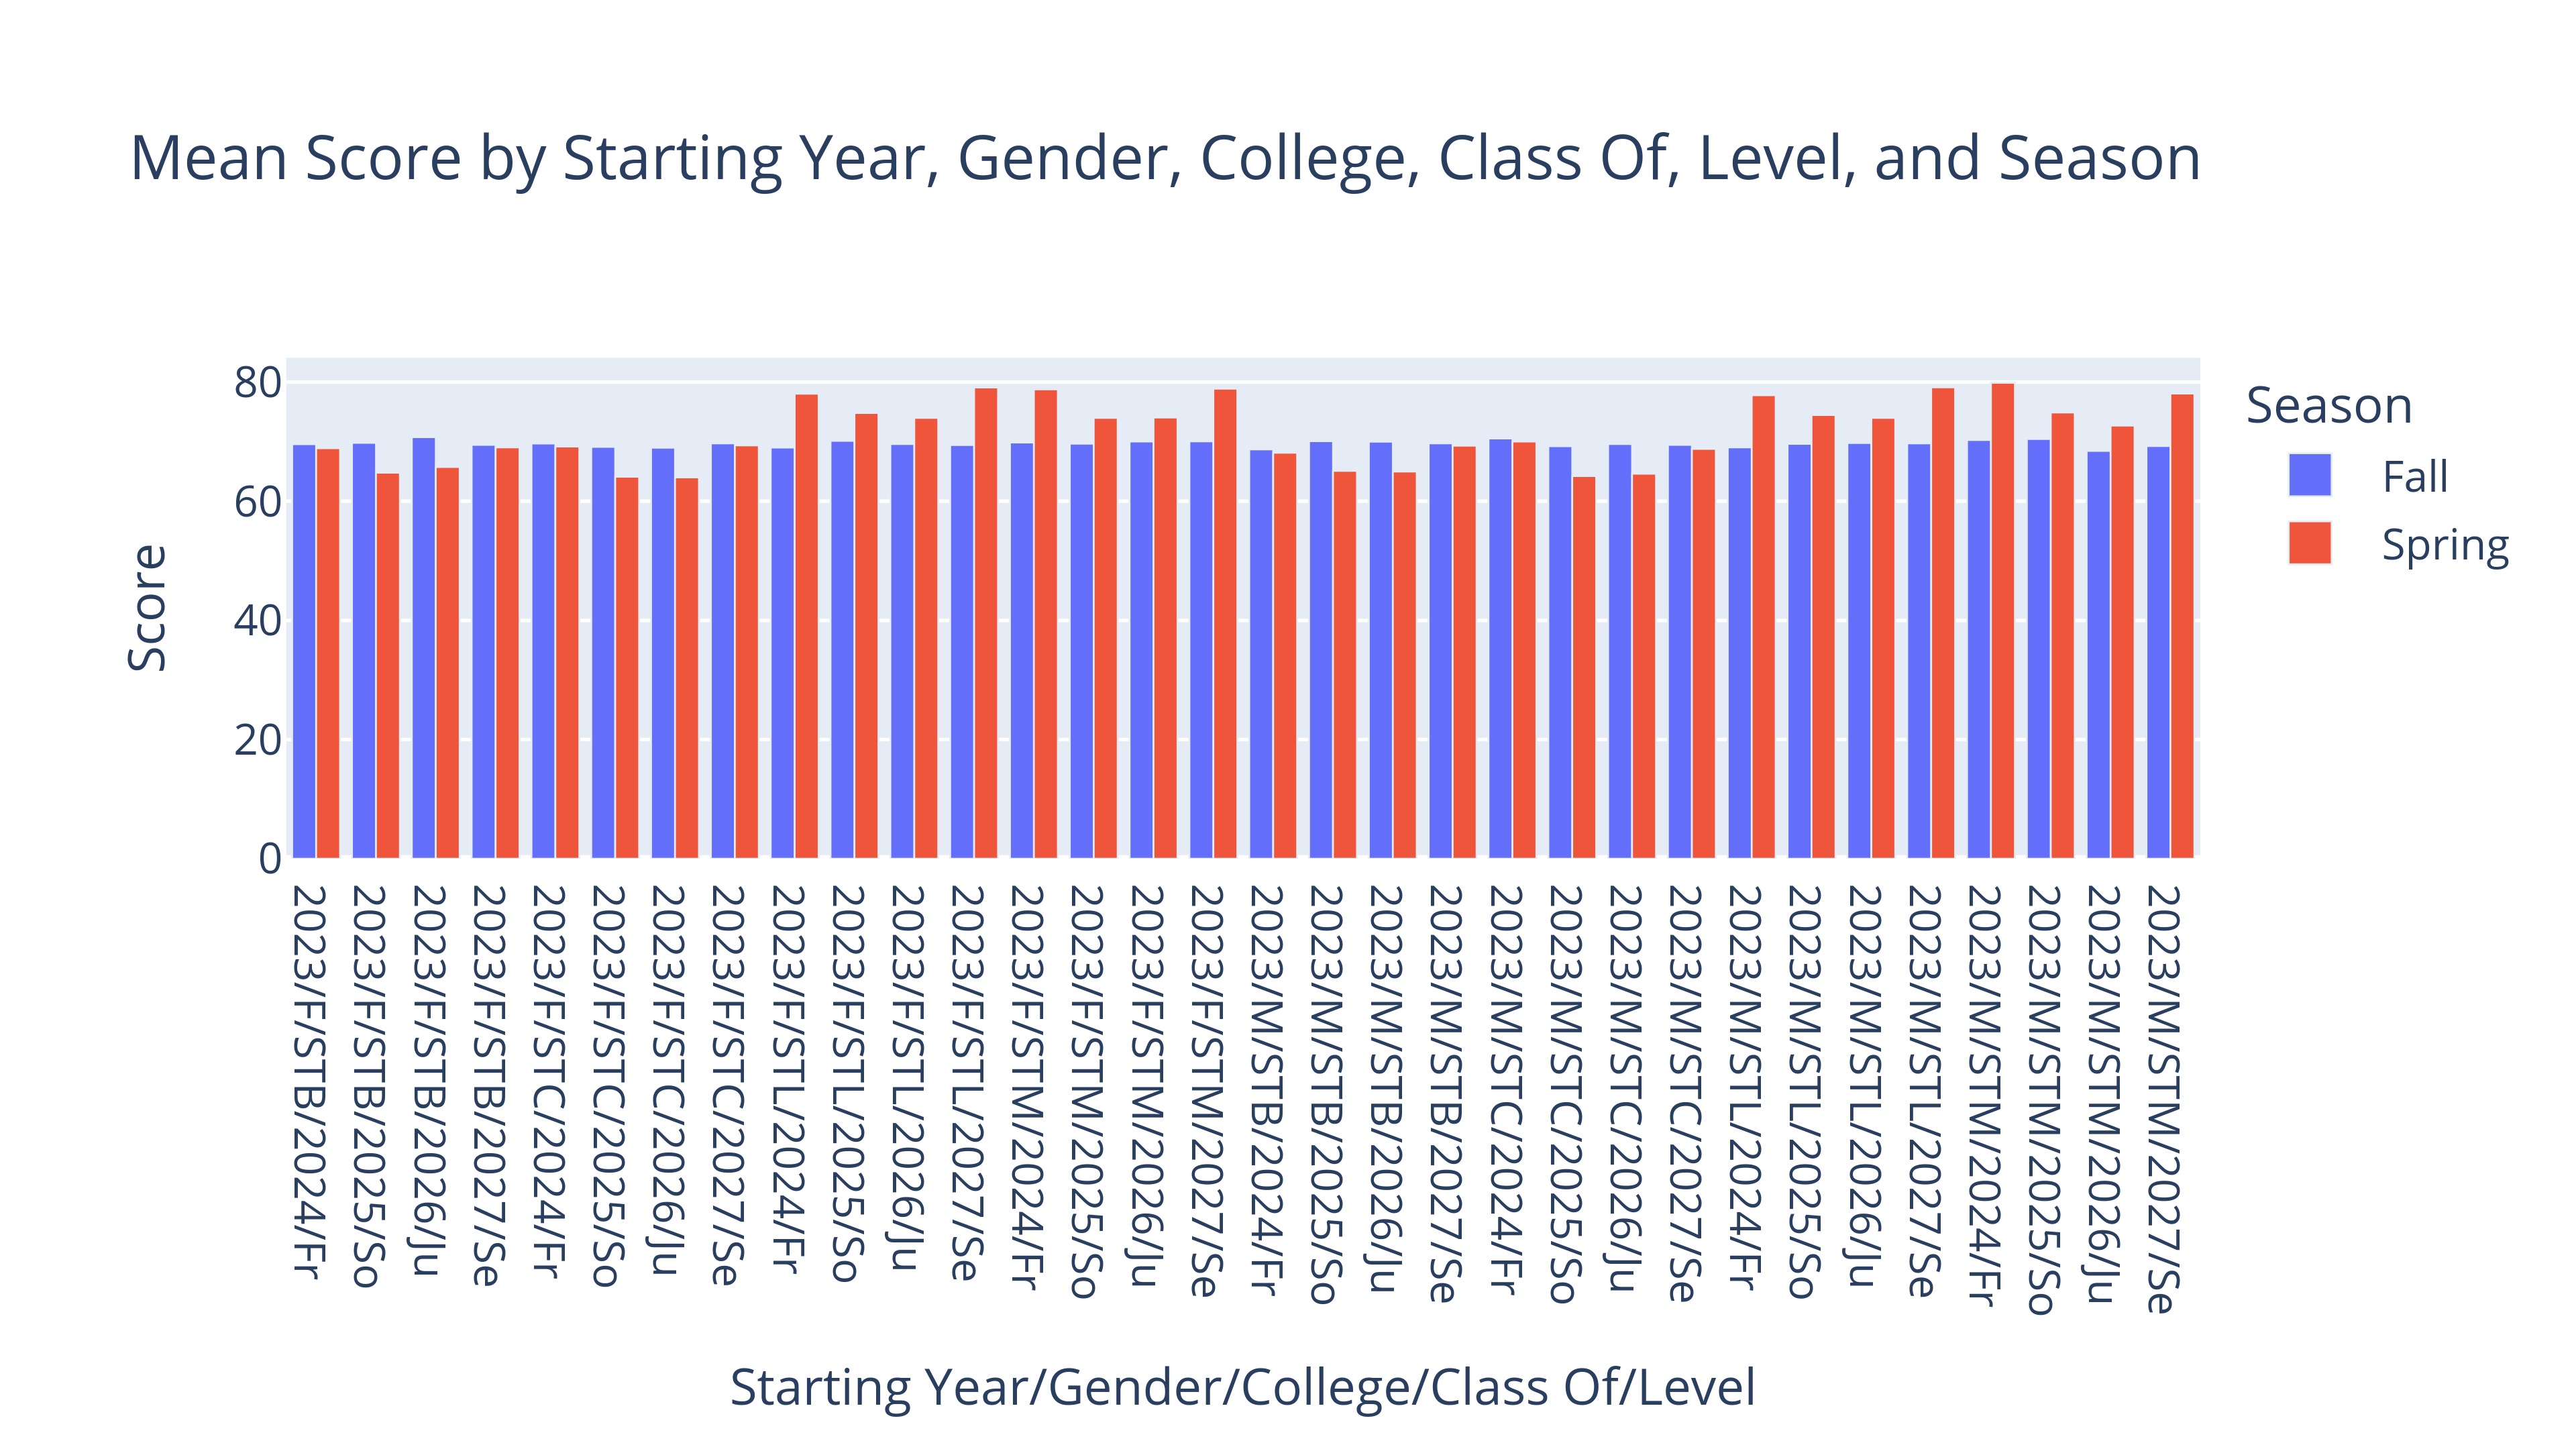

In [21]:
fig = autopivot_plus_bar(
    df = df_se, y = 'Score', 
    x_vars = [
        'Starting Year', 'Season', 'Gender', 'College', 'Class Of', 
        'Level For Sorting', 'Level'], 
    color = 'Season', 
    x_vars_to_exclude = ['Level For Sorting'],
    aggfunc = 'mean')      

wadi(fig=fig, 
     file_path='output/mean_score_by_6_variables_autopivot', 
     display_type=display_type)

The autopivot() and autobar() functions featured here can help speed up the process of creating standalone Plotly charts. However, these functions will prove even more useful within the Online Visualizations section of Python for Nonprofits--as they'll allow us to turn a small set of user inputs into a wide variety of charts and tables.